# Luftverschmutzung im Thurgau

Luftverschmutzung stellt ein zentrales Umwelt- und Gesundheitsproblem dar, insbesondere in Regionen mit hohem Verkehrsaufkommen. Verkehr gilt als eine der wichtigsten Quellen für Schadstoffe wie Stickoxide (NO₂) und Feinstaub (PM10), welche die Luftqualität erheblich beeinträchtigen können. Im Kanton Thurgau, speziell in der Gemeinde Weinfelden, treffen Wohngebiete, Durchgangsverkehr und wirtschaftliche Aktivitäten aufeinander, was die Frage nach dem Einfluss des Verkehrs auf die lokale Luftqualität besonders relevant macht. Für unsere Projektarbeit im Modul DAW haben wir uns somit für die folgende Fragestellung entschieden. 

**Ziel**: Hat der Verkehr in Weinfelden im Thurgau einen Einfluss auf die dortige Luftverschmutzung?

Als erstes geht es darum die Daten einzulesen und eine Überblick zu verschaffen.

# Quelle 1

## Beschreibung
Der Datensatz beinhaltet die Messergebnisse der Zählstellen für den motorisierten Individualverkehr auf Kantonsstrassen im Kanton Thurgau auf Stundenbasis. Die Zählstellen sind auf MET eingestellt (Spalten zeit_von und zeit_bis), d.h. die Zeitumstellung wird wie in Mitteleuropa ausgeführt. Bei der Umstellung von Winter- auf Sommerzeit fehlt die Stunde der Umstellung, dieser Tag hat dann 23 Stunden.

https://opendata.swiss/de/dataset/verkehrszahldaten-motorisierter-individualverkehr1

In [195]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from pathlib import Path
import folium
import osmnx as ox
from shapely.geometry import Point
import warnings
from IPython.display import display

Die erste Quelle liegt in Form eines GeoJSON vor. Damit sie auf jedem Betriebssystem gleich gelesen wird, wird das Encoding „utf-8” verwendet.

In [99]:
# utf-8 verwenden um einheitlich auf den Betriebssystemen lesbar zu sein
with open("../Data/Data_1.geojson", encoding="utf-8") as f:
    raw = json.load(f)  # als Dic speichern

features = raw["features"]

# Properties rausziehen (auch zeit_von und zeit_bis)
records = [feat["properties"] for feat in features]

# als pandas Dataframe formatieren
df = pd.DataFrame(records)

In [100]:
# Geomerie rauszeiehen und zu shapely objects konvertieren
df["geometry"] = [shape(feat["geometry"]) for feat in features]

# als Geo Daten Satz speichern
data1 = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

print(data1.shape)
print(data1.columns)
print(data1.head())

(62928, 17)
Index(['code', 'name', 'gemeinde', 'adresse', 'strasse', 'richtung',
       'spur_code', 'reg_bus', 'datum', 'zeit_von', 'zeit_bis', 'jahr',
       'monat', 'wochentag', 'stunde', 'anzahl', 'geometry'],
      dtype='object')
  code                                      name gemeinde  \
0  101  SCHLATT Kreuzung Paradies - Schaffhausen  Schlatt   
1  101  SCHLATT Kreuzung Paradies - Schaffhausen  Schlatt   
2  101  SCHLATT Kreuzung Paradies - Schaffhausen  Schlatt   
3  101  SCHLATT Kreuzung Paradies - Schaffhausen  Schlatt   
4  101  SCHLATT Kreuzung Paradies - Schaffhausen  Schlatt   

               adresse strasse          richtung  spur_code reg_bus  \
0  Diessenhoferstrasse     H13  von Schaffhausen          1    Nein   
1  Diessenhoferstrasse     H13  von Schaffhausen          1    Nein   
2  Diessenhoferstrasse     H13  von Schaffhausen          1    Nein   
3  Diessenhoferstrasse     H13  von Schaffhausen          1    Nein   
4  Diessenhoferstrasse     H13  von Schaf

## Datentypen

Überprüfung der Typen der jeweiligen Spalten, damit sie angepasst werden können falls nötig. 

In [101]:
type(data1)

geopandas.geodataframe.GeoDataFrame

In [102]:
data1.head()

,code,name,gemeinde,adresse,strasse,richtung,spur_code,reg_bus,datum,zeit_von,zeit_bis,jahr,monat,wochentag,stunde,anzahl,geometry
0,101,SCHLATT Kreuzung Paradies - Schaffhausen,Schlatt,Diessenhoferstrasse,H13,von Schaffhausen,1,Nein,2025-09-16,03:00,04:00,2025,9,Tuesday,3,7,POINT (8.68728 47.67926)
1,101,SCHLATT Kreuzung Paradies - Schaffhausen,Schlatt,Diessenhoferstrasse,H13,von Schaffhausen,1,Nein,2025-09-16,05:00,06:00,2025,9,Tuesday,5,87,POINT (8.68728 47.67926)
2,101,SCHLATT Kreuzung Paradies - Schaffhausen,Schlatt,Diessenhoferstrasse,H13,von Schaffhausen,1,Nein,2025-09-16,14:00,15:00,2025,9,Tuesday,14,309,POINT (8.68728 47.67926)
3,101,SCHLATT Kreuzung Paradies - Schaffhausen,Schlatt,Diessenhoferstrasse,H13,von Schaffhausen,1,Nein,2025-09-16,16:00,17:00,2025,9,Tuesday,16,468,POINT (8.68728 47.67926)
4,101,SCHLATT Kreuzung Paradies - Schaffhausen,Schlatt,Diessenhoferstrasse,H13,von Schaffhausen,1,Nein,2025-09-16,18:00,19:00,2025,9,Tuesday,18,339,POINT (8.68728 47.67926)


In [103]:
print(data1.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 62928 entries, 0 to 62927
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   code       62928 non-null  object  
 1   name       62928 non-null  object  
 2   gemeinde   62928 non-null  object  
 3   adresse    62352 non-null  object  
 4   strasse    60624 non-null  object  
 5   richtung   62928 non-null  object  
 6   spur_code  62928 non-null  int64   
 7   reg_bus    62928 non-null  object  
 8   datum      62928 non-null  object  
 9   zeit_von   62928 non-null  object  
 10  zeit_bis   62928 non-null  object  
 11  jahr       62928 non-null  object  
 12  monat      62928 non-null  int64   
 13  wochentag  62928 non-null  object  
 14  stunde     62928 non-null  int64   
 15  anzahl     62928 non-null  int64   
 16  geometry   62928 non-null  geometry
dtypes: geometry(1), int64(4), object(12)
memory usage: 8.2+ MB
None


Typumwandlung, damit Zahlen Integers sind und Zeitdaten als solche angegeben werden.

In [104]:
# datentypen anpassen
data1 = data1.astype(
    {
        "code": "Int64",
        "name": "string",
        "gemeinde": "category",
        "adresse": "string",
        "strasse": "string",
        "richtung": "string",
        "jahr": "Int64",
        "wochentag": "category",
    }
)

In [105]:
# die Spalte als binär speichern
data1["reg_bus"] = data1["reg_bus"].map({"JA": 1, "Nein": 0})

In [106]:
# Daten und Zeit konvertieren zu den entsprechenden Datentypen
data1["datum"] = pd.to_datetime(data1["datum"], errors="coerce").dt.date
data1["zeit_von"] = pd.to_datetime(
    data1["zeit_von"], format="%H:%M", errors="coerce"
).dt.time
data1["zeit_bis"] = pd.to_datetime(
    data1["zeit_bis"], format="%H:%M", errors="coerce"
).dt.time

Überprüfung der neuangepassten Datentypen der 1. Quelle

In [107]:
data1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 62928 entries, 0 to 62927
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   code       62928 non-null  Int64   
 1   name       62928 non-null  string  
 2   gemeinde   62928 non-null  category
 3   adresse    62352 non-null  string  
 4   strasse    60624 non-null  string  
 5   richtung   62928 non-null  string  
 6   spur_code  62928 non-null  int64   
 7   reg_bus    62928 non-null  int64   
 8   datum      62928 non-null  object  
 9   zeit_von   62928 non-null  object  
 10  zeit_bis   62928 non-null  object  
 11  jahr       62928 non-null  Int64   
 12  monat      62928 non-null  int64   
 13  wochentag  62928 non-null  category
 14  stunde     62928 non-null  int64   
 15  anzahl     62928 non-null  int64   
 16  geometry   62928 non-null  geometry
dtypes: Int64(2), category(2), geometry(1), int64(5), object(3), string(4)
memory usage: 7.4+ MB


## Statistik

Die statistischen Werte der numerischen Spalten werden angezeigt. Prüfen, ob es Ausreisser oder andere Abnormalitäten gibt.

In [108]:
data1.describe()

,code,spur_code,reg_bus,jahr,monat,stunde,anzahl
count,62928.0,62928.000000,62928.0,62928.0,62928.0,62928.000000,62928.000000
mean,31660.774218,1.009153,0.0,2025.0,9.0,11.500000,186.218281
std,20586.658922,0.095235,0.0,0.0,0.0,6.922242,188.712253
min,101.0,1.000000,0.0,2025.0,9.0,0.000000,0.000000
25%,9201.0,1.000000,0.0,2025.0,9.0,5.750000,26.000000
50%,40202.0,1.000000,0.0,2025.0,9.0,11.500000,131.000000
75%,41201.0,1.000000,0.0,2025.0,9.0,17.250000,295.000000
max,73703.0,2.000000,0.0,2025.0,9.0,23.000000,4046.000000


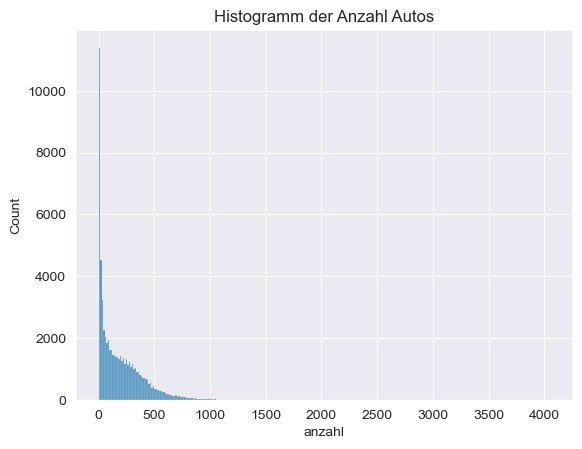

In [109]:
sns.histplot(data1, x="anzahl")
plt.title("Histogramm der Anzahl Autos")
plt.show()

Die Variablen "reg_bus", "jahr" und "monat" sind immer gleich, während die Variable "spur_code" zwischen 1 und 2 variiert. Die Spalte "stunde" beinhaltet die Stunden 0-23 vom Tag und die Spalte "code" bezieht sich auf die spezifischen Nummern der Region. Es gibt keine statistischen Ableitungen davon. Die einzige wichtige Spalte ist "anzahl", welche die Anzahl der Autos pro Stunde angibt. Es ist zu sehen, dass es einen Vorfall gab, bei dem 4.000 Autos gezählt wurden; alle anderen Werte scheinen näher beieinander zu liegen. Ausserdem gibt es viele Stunden ohne Autos.

## Bereinigen der Daten

Damit wir die Daten später sinnvoll analysieren können, müssen wir zuerst sicherstellen, dass sie keine gröberen Unsauberkeiten enthalten. Unvollständige oder fehlerhafte Einträge können die Auswertung verzerren und zu falschen Schlüssen führen. Aus diesem Grund prüfen und bereinigen wir die Rohdaten an dieser Stelle, bevor wir mit der eigentlichen Analyse fortfahren.

### Fehlende Werte Data1

Ein wichtiger Teil des Data Wranglings ist der Umgang mit fehlenden Werten. Bevor wir weitere Schritte planen, prüfen wir daher, in welchen Spalten Lücken vorkommen und wie umfangreich sie sind. Diese Übersicht bildet die Grundlage dafür, ob wir später Werte füllen, bereinigen oder einzelne Einträge entfernen müssen.

Mit dem folgenden Befehl lassen wir uns die Anzahl der fehlenden Werte pro Spalte anzeigen:

Dabei sehen wir, dass nur die Spalten __"adresse"__ und __"strasse"__ fehlende Daten haben.

In [110]:
data1.isna().sum()

code            0
name            0
gemeinde        0
adresse       576
strasse      2304
richtung        0
spur_code       0
reg_bus         0
datum           0
zeit_von        0
zeit_bis        0
jahr            0
monat           0
wochentag       0
stunde          0
anzahl          0
geometry        0
dtype: int64

### Analyse der fehlenden Adressen

Wir überprüfen, in welchen Gemeinden die fehlenden Adressen auftreten. Zuerst betrachten wir die fehlenden Adressen und danach auch die fehlenden Strassen.

Bei den Adressen sehen wir, dass alle fehlenden Einträge in der Frauenfeldgemeinde liegen. Das ist eine gute Neuigkeit für uns, da wir die Gemeinde Weinfelden in Focus nehmen.

In [111]:
adresse_data1 = data1[data1["adresse"].isna()]
print("So viele Adressendaten fehlen in folgenden Gemeinden:")
print(60 * "-")
adresse_data1["gemeinde"].value_counts()

So viele Adressendaten fehlen in folgenden Gemeinden:
------------------------------------------------------------


gemeinde
Frauenfeld      576
Aadorf            0
Kemmental         0
Tägerwilen        0
Sulgen            0
Schlatt           0
Münchwilen        0
Müllheim          0
Kreuzlingen       0
Güttingen         0
Affeltrangen      0
Bürglen           0
Bottighofen       0
Bischofszell      0
Amriswil          0
Altnau            0
Weinfelden        0
Name: count, dtype: int64

Wir sehen auch, dass die fehlenden Adressdaten in Frauenfeld etwa 4% der dortigen Adressdaten ausmachen.

In [112]:
adresse_ff_miss_proz = (
    adresse_data1["gemeinde"].value_counts()["Frauenfeld"]
    / data1["gemeinde"].value_counts()["Frauenfeld"]
)
adresse_ff_miss_proz

np.float64(0.040955631399317405)

### Analyse der fehlenden Strassen

Nun schauen wir uns an, wie die Verteilung der fehlenden Strassendaten aussieht. Wir sehen, dass alle fehlenden Einträge in drei Gemeinden auftreten: In Kreuzlingen fehlen 1104 Strassendaten, in Tägerwilen 624 und in Güttingen 576.

In [113]:
strasse_data1 = data1[data1["strasse"].isna()]
print("So viele Strassenendaten fehlen in folgenden Gemeinden:")
print(60 * "-")
strasse_data1["gemeinde"].value_counts()

So viele Strassenendaten fehlen in folgenden Gemeinden:
------------------------------------------------------------


gemeinde
Kreuzlingen     1104
Tägerwilen       624
Güttingen        576
Kemmental          0
Sulgen             0
Schlatt            0
Münchwilen         0
Müllheim           0
Aadorf             0
Affeltrangen       0
Frauenfeld         0
Bürglen            0
Bottighofen        0
Bischofszell       0
Amriswil           0
Altnau             0
Weinfelden         0
Name: count, dtype: int64

Wir sehen auch, dass die fehlenden Strassendaten in den Gemeinden prozentual höher ausfallen als die fehlenden Adressendaten in Frauenfeld. In Güttingen fehlen etwa 25 % der Strassendaten, in Kreuzlingen rund 12 % und in Tägerwilen gut 21 %.

In [114]:
# Zeilen filtern, in denen 'strasse' fehlt
strasse_data1 = data1[data1["strasse"].isna()]

print("So viele Strassendaten fehlen in folgenden Gemeinden:")
print("-" * 60)

# Anzahl fehlender Einträge pro Gemeinde
strasse_missing = strasse_data1["gemeinde"].value_counts()

# Gesamtanzahl Einträge pro Gemeinde
strasse_total = data1["gemeinde"].value_counts()

# Beides in einem DataFrame zusammenführen
strasse_stats = pd.DataFrame(
    {
        "Fehlend": strasse_missing,
        "Total": strasse_total,
    }
)

# Prozentsatz der fehlenden Einträge berechnen
strasse_stats["Prozent"] = (
    strasse_stats["Fehlend"] / strasse_stats["Total"] * 100
).round(2)

# Nur Gemeinden anzeigen, in denen Daten fehlen
strasse_stats = strasse_stats[strasse_stats["Fehlend"] > 0]

print(strasse_stats)

So viele Strassendaten fehlen in folgenden Gemeinden:
------------------------------------------------------------
             Fehlend  Total  Prozent
gemeinde                            
Güttingen        576   2304    25.00
Kreuzlingen     1104   9264    11.92
Tägerwilen       624   2928    21.31


### Imputieren der Strassendaten

Falls das Projekt später auch auf andere Gemeinden ausgeweitet wird, versuchen wir, die fehlenden Strassendaten zu ersetzen. Mithilfe der Geodaten sollte es möglich sein, die fehlenden Strassennamen mit Geopy zu imputieren. Zuerst wird geprüft, welche Geopunkte keine zugehörige Strasse haben.

Wir sehen dabei, dass 4 Punkte keine Strassenreferenznummer haben.

In [115]:
# Zeilen, wo 'strasse' fehlt
missing_strasse = data1[data1["strasse"].isna()]

# Gruppieren nach Geometrie und Häufigkeit zählen
geo_counts = (
    missing_strasse["geometry"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "geometry", "geometry": "count"})
)

# Ausgabe
print(f"{len(geo_counts)} eindeutige Punkte haben keine 'strasse'.")
geo_counts.head(10)

4 eindeutige Punkte haben keine 'strasse'.


,count,count
0,POINT (9.15975 47.66303),624
1,POINT (9.17542 47.64747),576
2,POINT (9.28795 47.60372),576
3,POINT (9.20103 47.63943),528


#### Strasse mit POINT (9.15975 47.66303)

Es wird jeder Punkt ohne Strassenrerferenznummer einzeln überprüft.

In [116]:
# gebrauch des Geocoder von OpenStreetMap
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.15975, 47.66303

# Adresse für Koordinate bekommen
location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 63800406, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 136372574, 'lat': '47.6631779', 'lon': '9.1596467', 'class': 'building', 'type': 'service', 'place_rank': 30, 'importance': 4.0923933775799455e-05, 'addresstype': 'building', 'name': '', 'display_name': '121, Konstanzerstrasse, Tägermoos, Tägerwilen, Bezirk Kreuzlingen, Thurgau, 8274, Schweiz/Suisse/Svizzera/Svizra', 'address': {'house_number': '121', 'road': 'Konstanzerstrasse', 'hamlet': 'Tägermoos', 'village': 'Tägerwilen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8274', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6631235', '47.6632316', '9.1595557', '9.1597377']}


Unter der Variable "class" ist zu sehen, dass der Geopunkt als Gebäude klassifiziert wird und nicht als Strasse. Um dies anzupassen wird der Zoom angepasst. 

In [117]:
location = geolocator.reverse(
    (47.66303, 9.15975),
    exactly_one=True,
    addressdetails=True,
    zoom=17,  # kleinerer Zoom -> höheres Objektniveau (Strasse statt Gebäude)
    timeout=10,
)
print(location.raw)

{'place_id': 64898907, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 927871226, 'lat': '47.6630259', 'lon': '9.1597506', 'class': 'highway', 'type': 'tertiary', 'place_rank': 26, 'importance': 0.05337425726710914, 'addresstype': 'road', 'name': 'Konstanzerstrasse', 'display_name': 'Konstanzerstrasse, Tägermoos, Tägerwilen, Bezirk Kreuzlingen, Thurgau, 8274, Schweiz/Suisse/Svizzera/Svizra', 'address': {'road': 'Konstanzerstrasse', 'hamlet': 'Tägermoos', 'village': 'Tägerwilen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8274', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6630040', '47.6630308', '9.1596117', '9.1597817']}


Nun wird vom Geolocator eine Strasse erkannt. Auf Google Maps ist zu sehen, dass die Strasse die Referenznummer 16 hat. Über Geohack  ist zu erkennen, dass die Koordinaten den Anfang der H16 bilden. Somit kann dieser Geopunkt mit dem Strassennamen H16 imputiert werden. 

Geohack: (https://geohack.toolforge.org/geohack.php?pagename=Hauptstrasse_16&language=de&params=47.663055555556_N_9.1599166666667_E_dim:500_region:CH-TG_type:building&title=Straßenbeginn+H16)

Mit dem folgenden Code imputieren wir die Daten für die Messtation mit den Geodaten 9.15975, 47.66303. Die hier eingefügte Toleranz wird verwendet, da Geopandas selbst die Daten etwas rundet.

In [118]:
target_x, target_y = (
    9.15975,
    47.66303,
)  # Geopandas macht ein unsichtbares runden -_- . Deswegen .isclose
tol = 1e-5  # Toleranz für kleine Rundungsunterschiede

mask = data1["strasse"].isna() & data1["geometry"].apply(
    lambda p: np.isclose(p.x, target_x, atol=tol)
    and np.isclose(p.y, target_y, atol=tol)
)

count_changed = mask.sum()

data1.loc[mask, "strasse"] = "H16"

print(f"{count_changed} Zeilen wurden geändert (strasse = 'H16').")

624 Zeilen wurden geändert (strasse = 'H16').


#### Strasse mit POINT (9.17542 47.64747)

Der Zoom musste auch hier angepasst werden, da ansonsten der Geopunkt nicht als Strasse sondern als Gebäude erkennt wird. 

In [119]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.17542, 47.64747

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 63782076, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 199880108, 'lat': '47.6473538', 'lon': '9.1751884', 'class': 'building', 'type': 'yes', 'place_rank': 30, 'importance': 5.6190585183444225e-05, 'addresstype': 'building', 'name': '', 'display_name': '70a, Hauptstrasse, Egelshofen, Bernrainzelg, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'house_number': '70a', 'road': 'Hauptstrasse', 'neighbourhood': 'Egelshofen', 'suburb': 'Bernrainzelg', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6472688', '47.6474388', '9.1750621', '9.1753147']}


Aus dem Output ist abzulesen, dass es sich um die Hauptstrasse in Kreuzlingen handelt. 

Um zu sehen, was für Strassen genau als Gemeindestrassen eingetragen wurden, werden die verschiedenen Geopunkte mit dem Strassenreferenzwert "Gemeindestrasse" rausgesucht. Somit kann nahe oder ähnliche Strassen erkennt werden, welche die selbe Bezeichnung haben. 

In [120]:
gemeinde_df = data1[data1["strasse"] == "Gemeindestrasse"]

# eindeutige Geopoints
gemeinde_points = gemeinde_df["geometry"].unique()

len(gemeinde_points)

# alle Zeilen bekommen mit den Gemeindestrassen geopoints
all_rows_same_points = data1[data1["geometry"].isin(gemeinde_points)]

(
    all_rows_same_points.groupby("geometry")["strasse"]
    .unique()
    .reset_index(name="strassen_am_punkt")
)

,geometry,strassen_am_punkt
0,POINT (8.90319 47.48851),[Gemeindestrasse]
1,POINT (9.024 47.46864),[Gemeindestrasse]
2,POINT (8.90851 47.54767),[Gemeindestrasse]
3,POINT (8.9088 47.54826),[Gemeindestrasse]
4,POINT (8.90019 47.55983),[Gemeindestrasse]
5,POINT (8.8995 47.56015),[Gemeindestrasse]
6,POINT (8.99554 47.59998),[Gemeindestrasse]
7,POINT (9.13672 47.56455),[Gemeindestrasse]
8,POINT (9.17478 47.64775),[Gemeindestrasse]
9,POINT (9.17516 47.64806),[Gemeindestrasse]


Basierend auf diesen Werten, kann davon ausgegangen werden, dass alle Strassen, welche keine Referenznummer haben als Gemeindestrasse gekennzeichnet wurden. 

Es werden die Zeilen 8-10 einzeln angeschaut, da diese in der Nähe von der eigentlichen Hauptstrasse zu sein scheinen. 

In [121]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.17478, 47.64775

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 63805423, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 208846417, 'lat': '47.6478590', 'lon': '9.1746287', 'class': 'building', 'type': 'apartments', 'place_rank': 30, 'importance': 5.6190585183444225e-05, 'addresstype': 'building', 'name': '', 'display_name': '2, Löwenstrasse, Egelshofen, Bernrainzelg, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'house_number': '2', 'road': 'Löwenstrasse', 'neighbourhood': 'Egelshofen', 'suburb': 'Bernrainzelg', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6477949', '47.6479263', '9.1744521', '9.1748064']}


Die Nebenstrasse von der eigentlich gesuchten Hauptstrasse ist die Löwenstrasse. Diese ist als Gemeindestrasse unter der Spalte "strasse" gespeichert. 

(https://www.openstreetmap.org/search?query=47.64775%2C+9.17478&zoom=18&minlon=9.172655940055849&minlat=47.64599791859759&maxlon=9.178213477134706&maxlat=47.648571064840354#map=19/47.647763/9.174700) 

In [122]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.17579, 47.6478

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 64029929, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 136893173, 'lat': '47.6479763', 'lon': '9.1763636', 'class': 'building', 'type': 'yes', 'place_rank': 30, 'importance': 5.6190585183444225e-05, 'addresstype': 'building', 'name': '', 'display_name': '8, Parkstrasse, Egelshofen, Bernrainzelg, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'house_number': '8', 'road': 'Parkstrasse', 'neighbourhood': 'Egelshofen', 'suburb': 'Bernrainzelg', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6479080', '47.6480496', '9.1761872', '9.1765405']}


Sowie auch die Parkstrasse, welche ebenfalls eine Nebenstrasse der Hauptstrasse in Kreuzlingen ist. Diese ist auch als Gemeindestrasse festgelegt.

(https://www.openstreetmap.org/search?query=47.6478%2C+9.17579&zoom=19&minlon=9.173310399055483&minlat=47.647120071696015&maxlon=9.176089167594911&maxlat=47.64840663302228#map=19/47.647799/9.175789)

In [123]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.17516, 47.64806

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 64025771, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 7589440172, 'lat': '47.6479787', 'lon': '9.1749432', 'class': 'shop', 'type': 'hearing_aids', 'place_rank': 30, 'importance': 5.6190585183444225e-05, 'addresstype': 'shop', 'name': 'Neuroth', 'display_name': 'Neuroth, 68, Hauptstrasse, Egelshofen, Bernrainzelg, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'shop': 'Neuroth', 'house_number': '68', 'road': 'Hauptstrasse', 'neighbourhood': 'Egelshofen', 'suburb': 'Bernrainzelg', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6479287', '47.6480287', '9.1748932', '9.1749932']}


Dieser Datenpunkt zeigt ebenfalls auf die Hauptstrasse von Kruezlingen. Dies ist im Output zu sehen, aber auch wenn man auf die OpenStreet Map geht. Kann man dies überprüfen. Somit können wir die gesuchte Strasse als "Gemeindestrasse" imputieren. 

(https://www.openstreetmap.org/search?query=47.64806%2C+9.17516&zoom=19&minlon=9.17439937591553&minlat=47.64715621149171&maxlon=9.177178144454958&maxlat=47.64844277192778#map=17/47.648007/9.174110)

In [124]:
target_x, target_y = (
    9.17542,
    47.64747,
)  # Geopandas macht ein unsichtbares runden -_- . Deswegen .isclose
tol = 1e-5  # Toleranz für kleine Rundungsunterschiede

mask = data1["strasse"].isna() & data1["geometry"].apply(
    lambda p: np.isclose(p.x, target_x, atol=tol)
    and np.isclose(p.y, target_y, atol=tol)
)

count_changed = mask.sum()

data1.loc[mask, "strasse"] = "Gemeindestrasse"

print(f"{count_changed} Zeilen wurden geändert (strasse = 'Gemeindestrasse').")

576 Zeilen wurden geändert (strasse = 'Gemeindestrasse').


#### Strasse mit POINT (9.28795 47.60372)

Erneut wird der Punkt als Gebäude klassifiziert. Erst nach der Anpassung des Zooms kann die Strasse erkennt werden. 

In [125]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.28795, 47.60372

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 63775103, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 410654929, 'lat': '47.6040391', 'lon': '9.2881384', 'class': 'building', 'type': 'house', 'place_rank': 30, 'importance': 3.582284275573385e-05, 'addresstype': 'building', 'name': '', 'display_name': '5, Bahnhofstrasse, Baslerhof, Güttingen, Bezirk Kreuzlingen, Thurgau, 8594, Schweiz/Suisse/Svizzera/Svizra', 'address': {'house_number': '5', 'road': 'Bahnhofstrasse', 'hamlet': 'Baslerhof', 'village': 'Güttingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8594', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6039730', '47.6041052', '9.2880415', '9.2882352']}


Da auf Google Maps dieser Punkt nicht auf einer klaren Hauptstrasse liegt, wird wieder nach Gemeindestrassen in der Nähe geschaut. Als erstes wird der Punkt 9.26583 47.61917 angeschaut. Dieser könnte am ehsten in der Nähe sein. 

In [126]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.26593, 47.61917

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 64105579, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 766414582, 'lat': '47.6191436', 'lon': '9.2658703', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.05337797436484318, 'addresstype': 'road', 'name': 'Bahnhofstrasse', 'display_name': 'Bahnhofstrasse, Altnau, Bezirk Kreuzlingen, Thurgau, 8595, Schweiz/Suisse/Svizzera/Svizra', 'address': {'road': 'Bahnhofstrasse', 'village': 'Altnau', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8595', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6190244', '47.6192159', '9.2657834', '9.2659104']}


Da die Bahnhofstrasse vom Nebendorf Altnau als Gemeindestrasse vorhanden ist, gehen wir davon aus, dass die Bahnhofstrasse von Güttingen auch als solche imputiert werden kann.

In [127]:
target_x, target_y = (
    9.28795,
    47.60372,
)  # Geopandas macht ein unsichtbares runden -_- . Deswegen .isclose
tol = 1e-5  # Toleranz für kleine Rundungsunterschiede

mask = data1["strasse"].isna() & data1["geometry"].apply(
    lambda p: np.isclose(p.x, target_x, atol=tol)
    and np.isclose(p.y, target_y, atol=tol)
)

count_changed = mask.sum()

data1.loc[mask, "strasse"] = "Gemeindestrasse"

print(f"{count_changed} Zeilen wurden geändert (strasse = 'Gemeindestrasse').")

576 Zeilen wurden geändert (strasse = 'Gemeindestrasse').


#### Strasse mit POINT (9.20103 47.63943)	

In [128]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.20103, 47.63943

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 414270275, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 202085063, 'lat': '47.6394320', 'lon': '9.2010466', 'class': 'highway', 'type': 'unclassified', 'place_rank': 26, 'importance': 0.053389523918516785, 'addresstype': 'road', 'name': 'Leubernstrasse', 'display_name': 'Leubernstrasse, Kurzrickenbach, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'road': 'Leubernstrasse', 'neighbourhood': 'Kurzrickenbach', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6393300', '47.6395771', '9.2010207', '9.2010586']}


Zuerst werden wieder die zwei nähsten Punkte zu dem gewünschten Geopoint angeschaut. 

In [129]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.18309, 47.64335

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 64836440, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 2082379487, 'lat': '47.6428557', 'lon': '9.1837763', 'class': 'amenity', 'type': 'bar', 'place_rank': 30, 'importance': 5.6190585183444225e-05, 'addresstype': 'amenity', 'name': 'Blaues Haus', 'display_name': 'Blaues Haus, 138, Hauptstrasse, Gaissberg, Kreuzlingen, Bezirk Kreuzlingen, Thurgau, 8280, Schweiz/Suisse/Svizzera/Svizra', 'address': {'amenity': 'Blaues Haus', 'house_number': '138', 'road': 'Hauptstrasse', 'neighbourhood': 'Gaissberg', 'town': 'Kreuzlingen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8280', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6428057', '47.6429057', '9.1837263', '9.1838263']}


In [130]:
geolocator = Nominatim(user_agent="adresse_filler")

lon, lat = 9.21135, 47.639

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 63808476, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 23059728, 'lat': '47.6389665', 'lon': '9.2114082', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.053370834668497714, 'addresstype': 'road', 'name': 'Moosfeldstrasse', 'display_name': 'Moosfeldstrasse, Lindenhof, Bottighofen, Bezirk Kreuzlingen, Thurgau, 8598, Schweiz/Suisse/Svizzera/Svizra', 'address': {'road': 'Moosfeldstrasse', 'hamlet': 'Lindenhof', 'village': 'Bottighofen', 'county': 'Bezirk Kreuzlingen', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8598', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.6373103', '47.6391157', '9.2104081', '9.2114881']}


Da die Leubernstrasse genauso, wie die Moosfeldstrasse von der H13 direkt abzweigt, nehmen wir an, dass diese auch als Gemeindestrasse erkannt werden kann. Die Koordinaten wurden wahrscheinlich nicht anerkannt, weil sie auf eine Fussgängerinsel zeigen und nicht direkt auf eine Strasse zeigt. 

(https://www.openstreetmap.org/search?query=47.639%2C+9.21135&zoom=16&minlon=9.18487071990967&minlat=47.63344117055761&maxlon=9.2071008682251&maxlat=47.64373546900487#map=16/47.63787/9.20543) 

In [131]:
target_x, target_y = (
    9.2010,
    47.63943,
)  # Geopandas macht ein unsichtbares runden -_- . Deswegen .isclose
tol = 1e-5  # Toleranz für kleine Rundungsunterschiede

mask = data1["strasse"].isna() & data1["geometry"].apply(
    lambda p: np.isclose(p.x, target_x, atol=tol)
    and np.isclose(p.y, target_y, atol=tol)
)

count_changed = mask.sum()

data1.loc[mask, "strasse"] = "Gemeindestrasse"

print(f"{count_changed} Zeilen wurden geändert (strasse = 'Gemeindestrasse').")

528 Zeilen wurden geändert (strasse = 'Gemeindestrasse').


### Imputieren der Adressendaten

Es ist zu sehen, dass alle unsere fehlenden Adressdaten nur von einem einzigen Punkt stammen. Also sollen wir ihn einfach mit den Geopunkten finden und imputieren können.

In [132]:
# Zeilten filtern nach fehlende Adressen
missing_adresse = data1[data1["adresse"].isna()]

# Duplikate droppen von Geopunkte
unique_missing = missing_adresse.drop_duplicates(subset="geometry")

print(f"{len(unique_missing)} unique points have no 'adresse'")
unique_missing

1 unique points have no 'adresse'


,code,name,gemeinde,adresse,strasse,richtung,spur_code,reg_bus,datum,zeit_von,zeit_bis,jahr,monat,wochentag,stunde,anzahl,geometry
19041,42101,FRAUENFELD Kreisel Rheinstrasse - Portal Nord,Frauenfeld,<NA>,H14,vom Portal Nord,1,0,2025-09-16,01:00:00,02:00:00,2025,9,Tuesday,1,2,POINT (8.89476 47.55772)


In [133]:
geolocator = Nominatim(user_agent="adresse_filler")

# genaue koordinaten anschauen
lon, lat = 8.89476, 47.55772

location = geolocator.reverse(
    (lat, lon), exactly_one=True, addressdetails=True, timeout=10
)
print(location.raw)

{'place_id': 65131708, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 693906752, 'lat': '47.5577136', 'lon': '8.8947600', 'class': 'highway', 'type': 'primary', 'place_rank': 26, 'importance': 0.05339150606546117, 'addresstype': 'road', 'name': '14', 'display_name': '14, Hinderem Dorf, Frauenfeld, Neunforn, Bezirk Frauenfeld, Thurgau, 8501, Schweiz/Suisse/Svizzera/Svizra', 'address': {'road': '14', 'neighbourhood': 'Hinderem Dorf', 'town': 'Frauenfeld', 'municipality': 'Neunforn', 'county': 'Bezirk Frauenfeld', 'state': 'Thurgau', 'ISO3166-2-lvl4': 'CH-TG', 'postcode': '8501', 'country': 'Schweiz/Suisse/Svizzera/Svizra', 'country_code': 'ch'}, 'boundingbox': ['47.5576044', '47.5577156', '8.8944778', '8.8958500']}


Der erkannte Name der Strasse ist 14. Auch auf OpenStreetMap ist zu sehen, dass die 14 einen kurzen Abschnitt zwischen zwei Kreiseln ist und keinen spezifischen Namen hat, abgsehen von der Zahl. 

(https://www.openstreetmap.org/search?query=47.55772%2C+8.89476&zoom=18&minlon=8.89197885990143&minlat=47.556429933842836&maxlon=8.897536396980287&maxlat=47.559007489324124#map=18/47.557720/8.894760)

In [134]:
geolocator = Nominatim(user_agent="adresse_filler")

# dictionary für schon angeschaute Koordinaten
adresse_cache = {}


def get_street_name(point, retries=3):
    if point is None or point.is_empty:
        return None

    # full-precision Koordinaten als cache key
    key = (point.y, point.x)

    # check cache
    if key in adresse_cache:
        return adresse_cache[key]

    # reverse geocoding versuchen
    for attempt in range(retries):
        try:
            location = geolocator.reverse(
                (point.y, point.x),
                exactly_one=True,
                addressdetails=True,
                timeout=10,
            )
            if location and "road" in location.raw["address"]:
                street_name = location.raw["address"]["road"]
                adresse_cache[key] = street_name
                return street_name
            adresse_cache[key] = None
            return None
        except GeocoderTimedOut:
            print(f"Timeout on attempt {attempt + 1}, retrying...")
            time.sleep(2)

    adresse_cache[key] = None
    return None


# nicht vorhandene Adressen raussuchen und auffüllen
mask = data1["adresse"].isna()
print(f"Found {mask.sum()} rows with missing 'adresse'.")

data1.loc[mask, "adresse"] = data1.loc[mask, "geometry"].apply(get_street_name)

print("Done filling missing 'adresse")

Found 576 rows with missing 'adresse'.
Done filling missing 'adresse


Jetzt sollten alle NAs aufgefüllt sein, damit es einen vollständigen Datensatz gibt, welcher für zukünftige Projekte verwendet werden kann. 

### Dublikate

In ersten Datensatz befinden sich keine Duplikate. Jedoch gibt es viele Zeilen (62352), welche ohne die Anzahl und die Fahrtrichtung gleich sind. Was berücksichtigt werden sollte. Dies macht Sinn, da wir zu jedem Zeitpunkt bei einer Messtation die Autos in beide Fahrtrichtungen getrennt zählen.

In [135]:
print(
    f"We  have so many completely duplicated rows: {data1.duplicated().sum()}"
)
print(60 * "-")
dupes = data1[
    data1.duplicated(
        subset=[
            col for col in data1.columns if col not in ["richtung", "anzahl"]
        ],
        keep=False,
    )
]
print(data1.shape)
print(
    f"Number of duplicated rows, if we ignore anzahl and direction: {len(dupes)}"
)

We  have so many completely duplicated rows: 0
------------------------------------------------------------
(62928, 17)
Number of duplicated rows, if we ignore anzahl and direction: 62352


# Quelle 2

Die zweite Quelle "Luftqualitätsmessungen Ostluft Thurgau – Stundenwerte" ist ebenfalls von opendata.swiss und beinhaltet die Luftwerte in Weinfelden und Konstanz. Für unsere Aufgabe wird jedoch nur Weinfelden verwendet werden. Die Daten werden aus dem automatischen Messnetz von Ostluft, das kontinuierlich verschiedene Luftschadstoffe (z.B. NO₂, PM₁₀, O₃) und teilweise meteorologische Parameter (z.B. Temperatur, Luftdruck, Wind) erfasst

https://opendata.swiss/de/dataset/luftqualitatsmessungen-ostluft-thurgau-stundenwerte 

Die zweite Quelle wird, auf Gründen der Vorgaben, als parquet-Datei eingelesen.

In [136]:
# Path.cwd() ist der Ordner des Notebooks.
# .parent geht eine Ebene höher in den Projekt-Hauptordner.
data_path = Path.cwd().parent / "Data" / "Data_2.parquet"

# Einlesen
data2 = pd.read_parquet(data_path, engine="fastparquet")
data2.head()

,startzeit,endzeit,messstelle,messwert,messstationid,indikator
0,2024-09-29 00:00:00,2024-09-29 01:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
1,2024-09-29 01:00:00,2024-09-29 02:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
2,2024-09-29 05:00:00,2024-09-29 06:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
3,2024-09-29 08:00:00,2024-09-29 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
4,2024-09-29 16:00:00,2024-09-29 17:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer


## Datentypen

Überprüfung der Datentypen und Anpassung falls nötig. 

In [137]:
type(data2)

pandas.core.frame.DataFrame

In [138]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19950 entries, 0 to 19949
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   startzeit      19950 non-null  datetime64[ms]
 1   endzeit        19950 non-null  datetime64[ms]
 2   messstelle     19950 non-null  object        
 3   messwert       19950 non-null  float64       
 4   messstationid  19950 non-null  object        
 5   indikator      19950 non-null  object        
dtypes: datetime64[ms](2), float64(1), object(3)
memory usage: 935.3+ KB


Anpassung der Datentypen von den Messstellen, MessstationIDs und den Indikatoren. 

In [139]:
# erstellung der Typzuweisung
data2 = data2.astype(
    {
        "messstelle": "category",
        "messstationid": "string",
        "indikator": "category",
    }
)

In [140]:
print(data2.info())
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19950 entries, 0 to 19949
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   startzeit      19950 non-null  datetime64[ms]
 1   endzeit        19950 non-null  datetime64[ms]
 2   messstelle     19950 non-null  category      
 3   messwert       19950 non-null  float64       
 4   messstationid  19950 non-null  string        
 5   indikator      19950 non-null  category      
dtypes: category(2), datetime64[ms](2), float64(1), string(1)
memory usage: 663.0 KB
None


,startzeit,endzeit,messstelle,messwert,messstationid,indikator
0,2024-09-29 00:00:00,2024-09-29 01:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
1,2024-09-29 01:00:00,2024-09-29 02:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
2,2024-09-29 05:00:00,2024-09-29 06:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
3,2024-09-29 08:00:00,2024-09-29 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
4,2024-09-29 16:00:00,2024-09-29 17:00:00,"Weinfelden, Berufsbildungszentrum",0.0,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer


## Statistik

Kurzen Blick auf einige statistische Metriken. Jedoch gibt es in diesem Datensatz nur der Messwert, der als Zahl vorhanden ist. 

In [141]:
data2.describe()

,startzeit,endzeit,messwert
count,19950,19950,19950.000000
mean,2025-05-20 11:23:58.195000,2025-05-20 12:23:58.556000,13.546316
min,2024-09-29 00:00:00,2024-09-29 01:00:00,-0.060000
25%,2025-01-15 18:15:00,2025-01-15 19:15:00,2.740000
50%,2025-07-29 10:00:00,2025-07-29 11:00:00,6.790000
75%,2025-08-29 16:00:00,2025-08-29 17:00:00,15.160000
max,2025-09-29 05:00:00,2025-09-29 06:00:00,235.120000
std,NaN,NaN,18.963322


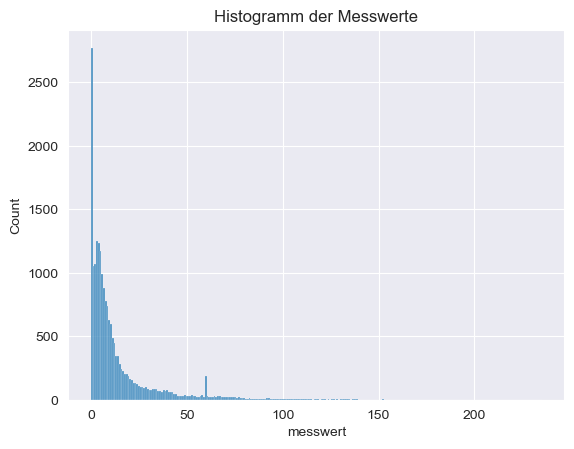

In [142]:
sns.histplot(data2, x="messwert")
plt.title("Histogramm der Messwerte")
plt.show()

## Bereinigen der Daten

### Ausreisser 

Zunächst werden die Daten auf Ausreisser überprüft. 
Es ist zu sehen, dass die Daten unregelmässig über den Zeitraum verteilt sind. Sie wurden von 2024-09-29 00:00:00+00:00 - 2025-09-29 05:00:00+00:00 erfasst. Jedoch wurde am August 2025 deutlich mehr Daten aufgenommen. Dies sollten wir uns für zukünftige Analysen im Kopf bewahren.

2024-09-29 00:00:00
2025-09-29 05:00:00


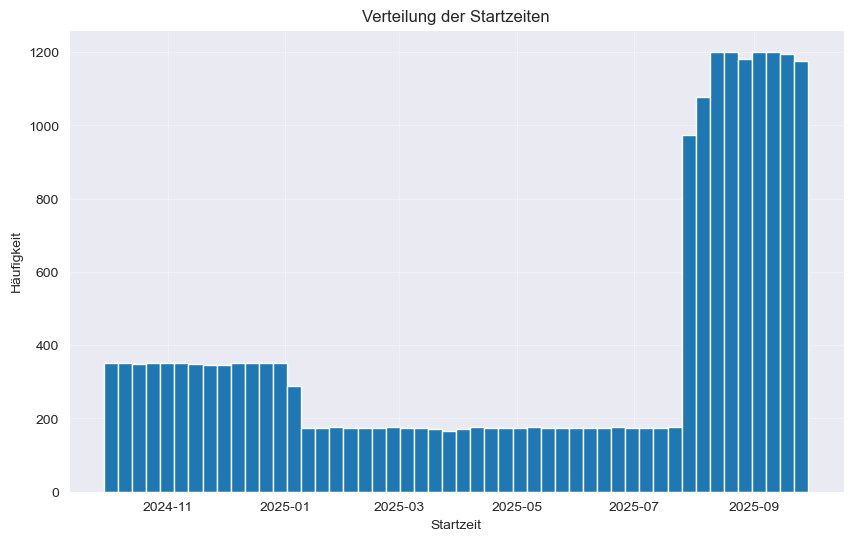

In [143]:
print(data2["startzeit"].min())
print(data2["startzeit"].max())

plt.figure(figsize=(10, 6))
plt.hist(data2["startzeit"], bins=50)
plt.title("Verteilung der Startzeiten")
plt.xlabel("Startzeit")
plt.ylabel("Häufigkeit")
plt.grid(True, alpha=0.3)
plt.show()

Das gleiche Muster ist logischerweise auch bei der Endzeit zu sehen. 

2024-09-29 01:00:00
2025-09-29 06:00:00


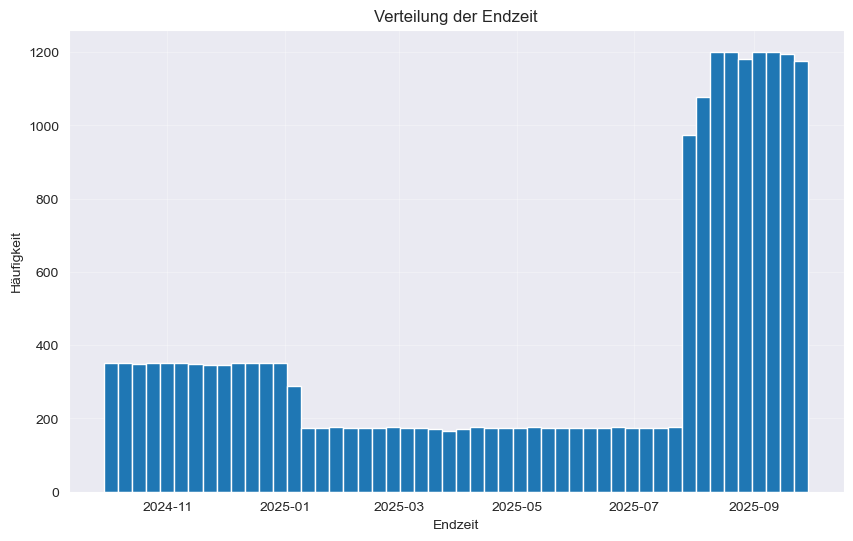

In [144]:
print(data2["endzeit"].min())
print(data2["endzeit"].max())

plt.figure(figsize=(10, 6))
plt.hist(data2["endzeit"], bins=50)
plt.title("Verteilung der Endzeit")
plt.xlabel("Endzeit")
plt.ylabel("Häufigkeit")
plt.grid(True, alpha=0.3)
plt.show()

Wichtig ist zu sehen, ob die Endzeit immer eine Stunde nach der Starzeit ist, da dies eine logische Konsequenz unserer Start-Endzeit Logik sein sollte.

Dabei ist aber zu sehen, dass dies in zwei Reihen nicht der Fall ist. In diesen zwei Reihen ist es jeweils doppelt so viel.

In [145]:
check = data2["endzeit"] == data2["startzeit"] + pd.Timedelta(hours=1)
print(check.value_counts())

True     19948
False        2
Name: count, dtype: int64


Hier geben wir die beiden Reihen aus. Bei den anderen Spalten sehen wir nichts, was auf falsche Daten hinweist. 
Natürlich stellt sich die Frage, was der Grund dahinter ist, dass es einen Zeitsprung von zwei Stunden statt einer STunde als Eintrag gibt.

Nach Überlegung kam uns da eine Hypothese. Es liegt an der Zeitumstellung. Die Uhr wird eine Stunde nach vorne verschoben. 
Dadurch wird 01:00 -> 02:00 zu 01:00 -> 03:00

In [146]:
data2[~check]

,startzeit,endzeit,messstelle,messwert,messstationid,indikator
216,2024-10-27 01:00:00,2024-10-27 03:00:00,"Weinfelden, Berufsbildungszentrum",0.00,8afbe850-6268-4c59-aa29-8405e7b6da6b,Regendauer
17117,2024-10-27 01:00:00,2024-10-27 03:00:00,"Konstanz, Wallgutstrasse",9.93,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)


**Anschauen ob bei Zeitumstellung auf Sommerzeit eine Zeitspanne fehlt**

Um unsere Hypothese der Zeitverschiebung der Winterzeit zu beweisen, schauen wir uns an, ob die Sommerzeit ebenfalls existiert. Dort sollte Start und endzeit gleich sein. 

Das finden wir jedoch leider nicht.

In [147]:
result = data2[data2["startzeit"] == data2["endzeit"]]
result

,startzeit,endzeit,messstelle,messwert,messstationid,indikator


Die Zeitumstellung war am 30. März 2025, wobe um Um 2:00 Uhr die Uhr auf 3:00 Uhr vorgestellt wird.

Wir haben leider keine Startzeit um 1:00 Uhr, welche unsere Hypothese verstärken oder widerlegen könnte.

In [148]:
result = data2[
    data2["startzeit"].dt.date == pd.Timestamp("2025-03-30").date()
].sort_values("startzeit")
result

,startzeit,endzeit,messstelle,messwert,messstationid,indikator
5619,2025-03-30 00:00:00,2025-03-30 01:00:00,"Konstanz, Wallgutstrasse",8.03,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
5620,2025-03-30 03:00:00,2025-03-30 04:00:00,"Konstanz, Wallgutstrasse",10.14,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
5621,2025-03-30 04:00:00,2025-03-30 05:00:00,"Konstanz, Wallgutstrasse",10.93,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
15055,2025-03-30 05:00:00,2025-03-30 06:00:00,"Konstanz, Wallgutstrasse",9.31,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
15056,2025-03-30 06:00:00,2025-03-30 07:00:00,"Konstanz, Wallgutstrasse",9.01,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
15057,2025-03-30 07:00:00,2025-03-30 08:00:00,"Konstanz, Wallgutstrasse",10.29,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
5622,2025-03-30 08:00:00,2025-03-30 09:00:00,"Konstanz, Wallgutstrasse",10.46,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
18322,2025-03-30 09:00:00,2025-03-30 10:00:00,"Konstanz, Wallgutstrasse",10.28,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
15058,2025-03-30 10:00:00,2025-03-30 11:00:00,"Konstanz, Wallgutstrasse",11.71,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)
18323,2025-03-30 11:00:00,2025-03-30 12:00:00,"Konstanz, Wallgutstrasse",11.53,9fc10577-4551-49aa-9ebc-2a882720c0ac,Feinstaub (PM2.5)


#### Was tun, mit diesen startzeit - endzeit Anomalien?

Zunächst wurde angenommen, dass die fehlenden Werte einfach interpoliert werden könnten – etwa indem die Regendauer auf 0 gesetzt und der Feinstaubanteil übernommen wird. Bei genauerer Betrachtung stellte sich jedoch heraus, dass der Zeitsprung von 1 bis 3 Uhr während der Zeitumstellung entsteht und daher plausibel ist.

Diese Annahme lässt sich grundsätzlich überprüfen, da eine Zeitumstellung sowohl eine Vorwärts- als auch eine Rückwärtsverschiebung der Uhrzeit beinhaltet. Die Rückwärsverschiebung ist nur durch das Fehlen der Stunde 1-2 und 2-3 ersichtlich.


Eine entsprechende Rückverschiebung konnte jedoch in den Daten nicht gefunden werden. Weiterhin fanden wir heraus, dass es im UTC format gar keine Zeitverschiebung gibt. Aus diesem Grund droppen wir die Daten.

In [149]:
mask = data2["endzeit"] == data2["startzeit"] + pd.Timedelta(hours=1)

dropped = (~mask).sum()

print("Gedroppte Datenreihen:", dropped)

data2 = data2[mask]

Gedroppte Datenreihen: 2


## Unique values und redundante Daten

Als nächstes schauen wir uns die Kategorischen Daten an. 
Dabei erkennen wir, dass bei der Indikatorspalte Feinstaub am meisten vorkommt, und Ozon am wenigsten.

Interessant ist auch, dass die Messtelle und Messtationsid beide gleiche value counts haben.

In [150]:
# unique werte für Spalten anschauen
print("Indikator Value counts:")
print(data2["indikator"].value_counts())
print(30 * "-")

print("Messstelle Value counts:")
print(data2["messstelle"].value_counts())
print(30 * "-")

print("Messstationid Value counts:")
print(data2["messstationid"].value_counts())
print(30 * "-")

Indikator Value counts:
indikator
Feinstaub (PM2.5)           8729
Regendauer                  2389
Feinstaub PM10              1539
Stickstoffdioxid            1473
Ozon                        1470
Stickoxide                  1468
Stickstoffmonoxid           1468
Ozon potentiell (O3+NO2)    1412
Name: count, dtype: int64
------------------------------
Messstelle Value counts:
messstelle
Konstanz, Wallgutstrasse             17559
Weinfelden, Berufsbildungszentrum     2389
Name: count, dtype: int64
------------------------------
Messstationid Value counts:
messstationid
9fc10577-4551-49aa-9ebc-2a882720c0ac    17559
8afbe850-6268-4c59-aa29-8405e7b6da6b     2389
Name: count, dtype: Int64
------------------------------


Nun überprüfen wir, ob die Messtation mit der Id immer übereinstimmt. Die Antwort auf diese Frage ist ja. 
Aus diesem Grund können wir __"messtationid"__ droppen

In [151]:
# stimmen alle Messstationen mit den IDs überein?
mapping_check = data2.groupby("messstationid")["messstelle"].nunique()

# Alle IDs anzeigen, die mehr als 1 verschiedene Messstelle haben
problematic = mapping_check[mapping_check > 1]

if problematic.empty:
    print("Jede messstationid gehört genau zu einer messstelle. (1:1 Mapping)")
    data2 = data2.drop(columns=["messstationid"])
else:
    print("Achtung: Diese IDs gehören zu mehreren Messstellen!")
    display(problematic)

Jede messstationid gehört genau zu einer messstelle. (1:1 Mapping)


### Fehlende Daten

Es sind keine direkte NA's vorhanden. Somit hat jede Zelle einen entsprechenden Wert.

In [152]:
data2.isna().sum()

startzeit     0
endzeit       0
messstelle    0
messwert      0
indikator     0
dtype: int64

### Ausreiser und NA durch Indikatoren

Da es insgesamt acht Indikatoren gibt, sollte jede Stunde acht Einträge enthalten, um vollständig zu sein und keine NA-Werte zu erzeugen. Für diese Analyse wird One-Hot-Encoding verwendet. Die Kombination aus Indikator und Messwert bildet dabei die Basis der Datenstruktur. 

In [153]:
# Gruppieren nach startzeit und endzeit und zählen, wie oft jede Kombination vorkommt
interval_counts = (
    data2.groupby(["startzeit", "endzeit"]).size().reset_index(name="count")
)

# Zählen, wie oft jede Häufigkeit vorkommt jede Zeile sollte 8 mal mit unterschiedlichen Indikatoren auftreten
count_summary = (
    interval_counts["count"].value_counts().sort_index(ascending=False)
)

print("Wie oft dieselbe Kombination aus startzeit → endzeit vorkommt:\n")
print(count_summary)

Wie oft dieselbe Kombination aus startzeit → endzeit vorkommt:

count
7    1412
5      56
4       4
3      55
2    2388
1    4827
Name: count, dtype: int64


Die Auswertung zeigt jedoch, dass viele Stunden nicht alle acht Indikatoren aufweisen. Beim Aufbrechen der Indikatorspalte werden deshalb zwangsläufig NA-Werte entstehen.

# Transformieren und Verknüpfen

Um die Verkehrsdaten aus beiden Quellen vergleichen zu können, müssen zunächst die Zeitangaben in data2 standardisiert werden – dazu wird 'startzeit' in ein datetime-Format konvertiert und in einzelne Spalten (Jahr, Monat, Tag, Uhrzeit) aufgeteilt. Anschliessend werden beide DataFrames auf das Jahr 2025 und die Messstelle "Weinfelden" gefiltert, um nur die relevanten Datensätze für die Analyse zu behalten. Abschliessend erfolgt ein Inner Join über die Spalte 'zeit_von', wodurch nur Zeitpunkte zusammengeführt werden, zu denen in beiden Datensätzen Messungen vorliegen.

In [154]:
# Zeitspalten erstellen
data2["startzeit"] = pd.to_datetime(data2["startzeit"])

# Aufsplitten
data2["jahr"] = data2["startzeit"].dt.year
data2["monat"] = data2["startzeit"].dt.month
data2["tag"] = data2["startzeit"].dt.day
data2["zeit_von"] = data2["startzeit"].dt.time

# Auf das Jahr 2025 filtern
data1_2025 = data1[(data1["jahr"] == 2025)]
data2_2025 = data2[(data2["jahr"] == 2025)]

# Nach Gemeinden/Messstellen filtern
data1_weinfelden = data1_2025[data1_2025["gemeinde"] == "Weinfelden"]

data2_weinfelden = data2_2025[
    data2_2025["messstelle"].str.contains("Weinfelden")
]

# Neue DataFrames erstellen durch Join auf zeit_von
df_weinfelden = data1_weinfelden.merge(
    data2_weinfelden, on="zeit_von", how="inner", suffixes=("_data1", "_data2")
)

print(f"Weinfelden: {len(df_weinfelden)} gemeinsame Zeilen")

Weinfelden: 22410 gemeinsame Zeilen


In [155]:
df_weinfelden.head()

,code,name,gemeinde,adresse,strasse,richtung,spur_code,reg_bus,datum,zeit_von,...,anzahl,geometry,startzeit,endzeit,messstelle,messwert,indikator,jahr_data2,monat_data2,tag
0,73701,WEINFELDEN Bankplatz - Bahnhofstrasse,Weinfelden,Bahnhofstrasse,K75,von Bahnhofstrasse,1,0,2025-09-16,08:00:00,...,330,POINT (9.10777 47.56578),2025-01-01 08:00:00,2025-01-01 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2025,1,1
1,73701,WEINFELDEN Bankplatz - Bahnhofstrasse,Weinfelden,Bahnhofstrasse,K75,von Bahnhofstrasse,1,0,2025-09-16,08:00:00,...,330,POINT (9.10777 47.56578),2025-01-02 08:00:00,2025-01-02 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2025,1,2
2,73701,WEINFELDEN Bankplatz - Bahnhofstrasse,Weinfelden,Bahnhofstrasse,K75,von Bahnhofstrasse,1,0,2025-09-16,08:00:00,...,330,POINT (9.10777 47.56578),2025-01-04 08:00:00,2025-01-04 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2025,1,4
3,73701,WEINFELDEN Bankplatz - Bahnhofstrasse,Weinfelden,Bahnhofstrasse,K75,von Bahnhofstrasse,1,0,2025-09-16,08:00:00,...,330,POINT (9.10777 47.56578),2025-01-05 08:00:00,2025-01-05 09:00:00,"Weinfelden, Berufsbildungszentrum",60.0,Regendauer,2025,1,5
4,73701,WEINFELDEN Bankplatz - Bahnhofstrasse,Weinfelden,Bahnhofstrasse,K75,von Bahnhofstrasse,1,0,2025-09-16,08:00:00,...,330,POINT (9.10777 47.56578),2025-01-03 08:00:00,2025-01-03 09:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2025,1,3


## Fehlerbehebung

Wenn der DataFrame nun genauer studiert wird, fällt auf, dass lediglich die Zeiten zusammen passen, aber nicht das Datum. Das ist ein Fehler der nicht passieren darf. Wir lassen den trotzdem hier drinnen, da er für unser Lernfortschritt wichtig ist.
Um den Fehler wieder gut zu machen, haben wir einen neuen Versuch gestartet, die Daten zu verknüpfen. Diesesmal schauen wir nebst der Startzeit auch auf das Datum.

In [156]:
# Zeitspalten für data1 konvertieren
data1["datum"] = pd.to_datetime(data1["datum"]).dt.date
data1["zeit_von"] = pd.to_datetime(
    data1["zeit_von"], format="%H:%M:%S"
).dt.time

# Zeitspalten erstellen für data2
data2["startzeit"] = pd.to_datetime(data2["startzeit"])
data2["jahr"] = data2["startzeit"].dt.year
data2["monat"] = data2["startzeit"].dt.month
data2["tag"] = data2["startzeit"].dt.day
data2["datum"] = data2["startzeit"].dt.date
data2["zeit_von"] = data2["startzeit"].dt.time


# Auf das Jahr 2025 filtern
data1_2025 = data1[data1["jahr"] == 2025]
data2_2025 = data2[data2["jahr"] == 2025]

# Nach Gemeinden/Messstellen filtern
data1_weinfelden = data1_2025[data1_2025["gemeinde"] == "Weinfelden"]
data1_konstanz = data1_2025[data1_2025["gemeinde"] == "Konstanz"]

data2_weinfelden = data2_2025[
    data2_2025["messstelle"].str.contains("Weinfelden")
]
data2_konstanz = data2_2025[data2_2025["messstelle"].str.contains("Konstanz")]

# Spalten zum Entfernen definieren
zu_entfernen_data2 = ["startzeit", "endzeit"]

# Neue DataFrames erstellen
df_weinfelden = data1_weinfelden.merge(
    data2_weinfelden.drop(columns=zu_entfernen_data2),
    on=["datum"],
    how="inner",
)

df_konstanz = data1_konstanz.merge(
    data2_konstanz.drop(columns=zu_entfernen_data2), on=["datum"], how="inner"
)

print(f"Weinfelden: {len(df_weinfelden)} gemeinsame Zeilen")

Weinfelden: 0 gemeinsame Zeilen


## Problembeschreibung

Nun stehen wir vor einem gravierenden Problem: Es gibt insgesamt 0 gemeinsame Datenpunkte für Weinfelden. In unserem ursprünglichen Pitch waren wir davon ausgegangen, ausreichend übereinstimmende Daten zu haben, um unsere Fragestellung zum Weinfeldner Verkehr fundiert beantworten zu können. Stattdessen müssen wir nun die Ursache für diese fehlenden Übereinstimmungen analysieren und geeignete Lösungsansätze entwickeln.

## Fehleruntersuchung

In unserem Pitch hatten wir anhand des Monats September 2025 gezeigt, dass ausreichend gemeinsame Datenpunkte vorhanden sind. Dies steht im Widerspruch zur aktuellen Analyse, die für das gesamte Jahr 2025 null Übereinstimmungen ergab. Um diese Diskrepanz aufzuklären, untersuchen wir nun gezielt die Datenverteilung im September 2025 – und zwar separat für data1 und data2, visualisiert als Barplots pro Datum.

2025-12-29 15:38:09,038 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 15:38:09,045 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


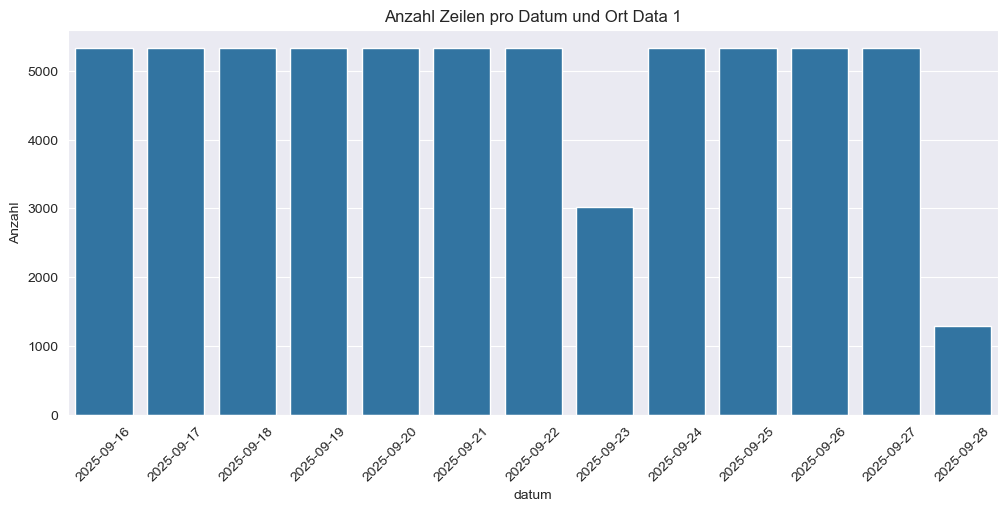

2025-12-29 15:38:09,298 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 15:38:09,311 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


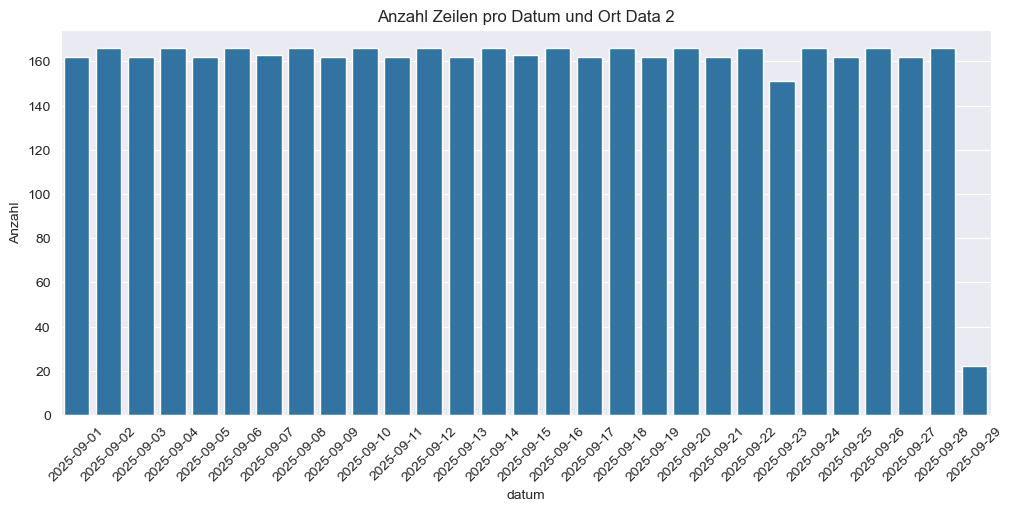

In [157]:
# Filter für September 2025
data1["datum"] = pd.to_datetime(data1["datum"])
df_sep25 = data1[
    (data1["datum"].dt.year == 2025) & (data1["datum"].dt.month == 9)
]
# jetzt Anzahl Zeilen pro Datum zählen
counts = df_sep25["datum"].value_counts().reset_index()
counts.columns = ["datum", "Anzahl"]
counts = counts.sort_values("datum")

# Barplot zeichnen
plt.figure(figsize=(12, 5))
sns.barplot(data=counts, x="datum", y="Anzahl")

plt.xticks(rotation=45)  # Damit die Daten lesbarer sind
plt.title("Anzahl Zeilen pro Datum und Ort Data 1")
plt.show()

# Filter für September 2025
data2["datum"] = pd.to_datetime(data2["datum"])
df_sep25 = data2[
    (data2["datum"].dt.year == 2025) & (data2["datum"].dt.month == 9)
]
# jetzt Anzahl Zeilen pro Datum zählen
counts = df_sep25["datum"].value_counts().reset_index()
counts.columns = ["datum", "Anzahl"]
counts = counts.sort_values("datum")

# Barplot zeichnen
plt.figure(figsize=(12, 5))
sns.barplot(data=counts, x="datum", y="Anzahl")

plt.xticks(rotation=45)  # Damit die Daten lesbarer sind
plt.title("Anzahl Zeilen pro Datum und Ort Data 2")
plt.show()

### Analyse gemeinsamer Datumswerte

Die vorherigen Plots zeigen, dass sowohl data1 als auch data2 für September 2025 "gemeinsame" Daten enthalten – dennoch ergab der Join null Übereinstimmungen. Um dieser Diskrepanz auf den Grund zu gehen, untersuchen wir nun systematisch, an welchen Tagen überhaupt Messungen in beiden Datensätzen vorliegen. Wir vermuten, dass möglicherweise die Daten in data2 nur für Konstanz statt für Weinfelden vorliegen, was die fehlenden Übereinstimmungen erklären würde.

In [158]:
# Datum konvertieren für beide DataFrames
data1["datum"] = pd.to_datetime(data1["datum"]).dt.date
data2["datum"] = data2["startzeit"].dt.date

# Einzigartige Daten extrahieren
daten_data1 = set(data1["datum"].unique())
daten_data2 = set(data2["datum"].unique())

# Gemeinsame Daten finden
gemeinsame_daten = daten_data1.intersection(daten_data2)

print(f"Anzahl Tage in data1: {len(daten_data1)}")
print(f"Anzahl Tage in data2: {len(daten_data2)}")
print(f"Anzahl gemeinsame Tage: {len(gemeinsame_daten)}")
print("\nErste 10 gemeinsame Daten:")
print(sorted(gemeinsame_daten)[:10])

# Optional: Daten nur in data1 oder nur in data2
nur_data1 = daten_data1 - daten_data2
nur_data2 = daten_data2 - daten_data1

print(f"\nTage nur in data1: {len(nur_data1)}")
print(f"Tage nur in data2: {len(nur_data2)}")

Anzahl Tage in data1: 13
Anzahl Tage in data2: 366
Anzahl gemeinsame Tage: 13

Erste 10 gemeinsame Daten:
[datetime.date(2025, 9, 16), datetime.date(2025, 9, 17), datetime.date(2025, 9, 18), datetime.date(2025, 9, 19), datetime.date(2025, 9, 20), datetime.date(2025, 9, 21), datetime.date(2025, 9, 22), datetime.date(2025, 9, 23), datetime.date(2025, 9, 24), datetime.date(2025, 9, 25)]

Tage nur in data1: 0
Tage nur in data2: 353


### Ergebnis: Gemeinsame Tage identifiziert

Die Analyse zeigt, dass es 13 gemeinsame Tage zwischen beiden Datensätzen gibt (16. bis 28. September 2025). Alle Tage aus data1 kommen auch in data2 vor, während data2 insgesamt 366 Tage abdeckt. Dies bestätigt, dass grundsätzlich überlappende Zeiträume existieren – das Problem der fehlenden Join-Ergebnisse muss also eine andere Ursache haben.

In [159]:
# Datum konvertieren für beide DataFrames
data1["datum"] = pd.to_datetime(data1["datum"]).dt.date
data2["datum"] = data2["startzeit"].dt.date

# Einzigartige Daten extrahieren
daten_data1 = set(data1["datum"].unique())
daten_data2 = set(data2["datum"].unique())

# Gemeinsame Daten finden
gemeinsame_daten = daten_data1.intersection(daten_data2)

print(f"Anzahl gemeinsame Tage: {len(gemeinsame_daten)}")

# Nur Zeilen mit gemeinsamen Daten filtern
data1_gemeinsam = data1[data1["datum"].isin(gemeinsame_daten)]
data2_gemeinsam = data2[data2["datum"].isin(gemeinsame_daten)]

# Gemeinden in den gefilterten Daten
gemeinden_data1 = set(data1_gemeinsam["gemeinde"].unique())
messstellen_data2 = list(
    data2_gemeinsam["messstelle"].unique()
)  # Als Liste konvertieren!

print(f"\nGemeinden in data1 (an gemeinsamen Tagen): {gemeinden_data1}")
print("\nMessstellen in data2 (an gemeinsamen Tagen):")
for m in messstellen_data2:
    print(f"  - {m}")

# DEBUG: Teste manuell
print("\n--- DEBUG ---")
test_gemeinde = "Weinfelden"
for messstelle in messstellen_data2:
    print(
        f"'{test_gemeinde.lower()}' in '{messstelle.lower()}': {test_gemeinde.lower() in messstelle.lower()}"
    )

# Prüfen welche Gemeinden überlappen
gemeinsame_gemeinden = []
for gemeinde in gemeinden_data1:
    gefunden = any(
        gemeinde.lower() in messstelle.lower()
        for messstelle in messstellen_data2
    )
    if gefunden:
        gemeinsame_gemeinden.append(gemeinde)
        print(f"Gemeinde '{gemeinde}': GEFUNDEN")

print(f"\nGemeinsame Gemeinden: {gemeinsame_gemeinden}")
print(f"Anzahl gemeinsame Gemeinden: {len(gemeinsame_gemeinden)}")

Anzahl gemeinsame Tage: 13

Gemeinden in data1 (an gemeinsamen Tagen): {'Tägerwilen', 'Bottighofen', 'Affeltrangen', 'Schlatt', 'Altnau', 'Kreuzlingen', 'Amriswil', 'Frauenfeld', 'Müllheim', 'Güttingen', 'Weinfelden', 'Sulgen', 'Münchwilen', 'Kemmental', 'Aadorf', 'Bürglen', 'Bischofszell'}

Messstellen in data2 (an gemeinsamen Tagen):
  - Konstanz, Wallgutstrasse

--- DEBUG ---
'weinfelden' in 'konstanz, wallgutstrasse': False

Gemeinsame Gemeinden: []
Anzahl gemeinsame Gemeinden: 0


### Ursache identifiziert: Räumliche statt zeitliche Diskrepanz

An den 13 gemeinsamen Tagen zeigt sich das eigentliche Problem:

In data2 gibt es an diesen Tagen ausschlielich Daten für "Konstanz, Wallgutstrasse", nicht aber für Weinfelden. Obwohl data1 17 verschiedene Gemeinden (inklusive Weinfelden) enthält, findet sich keine Übereinstimmung mit den Messstellen in data2. Die Vermutung, dass data2 möglicherweise hauptsächlich Konstanz-Daten enthält, bestätigt sich damit.

In [160]:
# Datum konvertieren für beide DataFrames
data1["datum"] = pd.to_datetime(data1["datum"]).dt.date
data2["datum"] = data2["startzeit"].dt.date

# Prüfe alle Messstellen in data2
print("Alle Messstellen in data2:")
print(data2["messstelle"].unique())

# Filtere data1 nach Weinfelden
data1_weinfelden = data1[data1["gemeinde"] == "Weinfelden"]
print(f"\nAnzahl Zeilen mit Weinfelden in data1: {len(data1_weinfelden)}")
print(
    f"Datum-Bereich Weinfelden in data1: {data1_weinfelden['datum'].min()} bis {data1_weinfelden['datum'].max()}"
)

# Filtere data2 nach Weinfelden
data2_weinfelden = data2[
    data2["messstelle"].str.contains("Weinfelden", case=False, na=False)
]
print(f"\nAnzahl Zeilen mit Weinfelden in data2: {len(data2_weinfelden)}")
print(
    f"Datum-Bereich Weinfelden in data2: {data2_weinfelden['datum'].min()} bis {data2_weinfelden['datum'].max()}"
)

# Gemeinsame Daten nur für Weinfelden
daten_weinfelden_data1 = set(data1_weinfelden["datum"].unique())
daten_weinfelden_data2 = set(data2_weinfelden["datum"].unique())
gemeinsame_weinfelden = daten_weinfelden_data1.intersection(
    daten_weinfelden_data2
)

print(f"\nGemeinsame Tage für Weinfelden: {len(gemeinsame_weinfelden)}")
print(f"Erste 5 gemeinsame Tage: {sorted(gemeinsame_weinfelden)[:5]}")

Alle Messstellen in data2:
['Weinfelden, Berufsbildungszentrum', 'Konstanz, Wallgutstrasse']
Categories (2, object): ['Konstanz, Wallgutstrasse', 'Weinfelden, Berufsbildungszentrum']

Anzahl Zeilen mit Weinfelden in data1: 3984
Datum-Bereich Weinfelden in data1: 2025-09-16 bis 2025-09-28

Anzahl Zeilen mit Weinfelden in data2: 2389
Datum-Bereich Weinfelden in data2: 2024-09-29 bis 2025-01-06

Gemeinsame Tage für Weinfelden: 0
Erste 5 gemeinsame Tage: []


### Zeitliche Überprüfung der Weinfelden-Daten

Nun zeigt sich die tatsächliche Ursache:

Obwohl beide Datensätze Daten für Weinfelden enthalten (3.984 Zeilen in data1, 2.390 Zeilen in data2), liegen die Erfassungszeiträume zeitlich versetzt. Data1 deckt den Zeitraum 16. bis 28. September 2025 ab, während data2 für Weinfelden nur Daten vom 29. September 2024 bis 6. Januar 2025 enthält. Diese zeitliche Nicht-Überlappung erklärt, warum der Join null Ergebnisse lieferte.

# Problemlösung: Neue Daten für 2024

Da für Weinfelden im Jahr 2025 keine zeitlichen Überschneidungen zwischen beiden Datensätzen existieren, wurden von der Webseite von data1 die vollständigen Daten für das Jahr 2024 als CSV-Datei heruntergeladen. Für die weitere Analyse wird ausschlielich die Gemeinde Weinfelden betrachtet, da data2 für diesen Standort Messwerte im Zeitraum September 2024 bis Januar 2025 enthält – somit lässt sich nun ein gemeinsamer Analysezeitraum in 2024 realisieren.

In [161]:
data1 = pd.read_csv("../Data/Data_1_neu.csv")

In [162]:
data1_weinfelden = data1[data1["gemeinde"] == "Weinfelden"].copy()
data1_weinfelden.dropna(inplace=True)

In [163]:
data1_weinfelden.head()

,code,name,gemeinde,adresse,strasse,richtung,spur_code,reg_bus,datum,zeit_von,...,mr,pw,pw+,lief,lief+,lief+aufl.,lw,lw+,sattelzug,koordinaten
618912,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Weinfelden,Wilerstrasse,K80,vom Zentrum,1,Nein,2024-01-01,00:00,...,1,45,0,0,0,0,0,0,0,"47.56203294714044,9.107583081916452"
618913,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Weinfelden,Wilerstrasse,K80,vom Zentrum,1,Nein,2024-01-01,01:00,...,0,44,0,1,0,0,0,0,0,"47.56203294714044,9.107583081916452"
618914,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Weinfelden,Wilerstrasse,K80,vom Zentrum,1,Nein,2024-01-01,02:00,...,0,31,0,1,0,0,0,0,0,"47.56203294714044,9.107583081916452"
618915,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Weinfelden,Wilerstrasse,K80,vom Zentrum,1,Nein,2024-01-01,03:00,...,0,23,0,0,0,0,0,0,0,"47.56203294714044,9.107583081916452"
618916,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Weinfelden,Wilerstrasse,K80,vom Zentrum,1,Nein,2024-01-01,04:00,...,0,11,0,0,0,0,0,0,0,"47.56203294714044,9.107583081916452"


## Erneutes Transformieren

Der neue Datensatz wird nun so aufbereitet, dass ein erneuter Join möglich sein sollte. 

In [164]:
# Datentyp anpassung
data1_weinfelden = data1_weinfelden.astype(
    {
        "code": "Int64",
        "name": "string",
        "gemeinde": "category",
        "adresse": "string",
        "strasse": "string",
        "richtung": "string",
        "jahr": "Int64",
        "wochentag": "category",
    }
)

In [165]:
# die Spalte als binär speichern
data1_weinfelden["reg_bus"] = data1_weinfelden["reg_bus"].map(
    {"JA": 1, "Nein": 0}
)

In [166]:
# Daten und Zeit konvertieren zu den entsprechenden Datentypen
data1_weinfelden["datum"] = pd.to_datetime(
    data1_weinfelden["datum"], errors="coerce"
).dt.date
data1_weinfelden["zeit_von"] = pd.to_datetime(
    data1_weinfelden["zeit_von"], format="%H:%M", errors="coerce"
).dt.time
data1_weinfelden["zeit_bis"] = pd.to_datetime(
    data1_weinfelden["zeit_bis"], format="%H:%M", errors="coerce"
).dt.time

Die jeweiligen Spalten sollten sinnvoll umbenennt werden und auch auf Deutsch übersetzt. 

In [167]:
data1_weinfelden = data1_weinfelden.rename(
    columns={
        "reg_bus": "Regional Bus",
        "mr": "Motorrad",
        "pw": "Personenwagen",
        "pw+": "Personenwagen mit anhänger",
        "lief": "Lieferwagen",
        "lief+": "Lieferwagen mit anhänger",
        "lief+aufl.": "Lieferwagen mit auflieger",
        "lw": "Lastwagen",
        "lw+": "Lastwagen mit anhänger",
    }
)
data1_weinfelden["wochentag"] = data1_weinfelden[
    "wochentag"
].cat.rename_categories(
    {
        "Sunday": "Sonntag",
        "Monday": "Montag",
        "Tuesday": "Dienstag",
        "Wednesday": "Mittwoch",
        "Thursday": "Donnerstag",
        "Friday": "Freitag",
        "Saturday": "Samstag",
    }
)

data1_weinfelden["datum"] = pd.to_datetime(data1_weinfelden["datum"])

# Abgeleitete Zeitvariablen
data1_weinfelden["jahr"] = data1_weinfelden["datum"].dt.year
data1_weinfelden["monat"] = data1_weinfelden["datum"].dt.month
data1_weinfelden["woche"] = data1_weinfelden["datum"].dt.isocalendar().week
data1_weinfelden["ist_wochenende"] = data1_weinfelden["wochentag"].isin(
    ["Samstag", "Sonntag"]
)
data1_weinfelden["pkw_total"] = (
    data1_weinfelden["Personenwagen"]
    + data1_weinfelden["Personenwagen mit anhänger"]
)
data1_weinfelden["lieferwagen_total"] = (
    data1_weinfelden["Lieferwagen"]
    + data1_weinfelden["Lieferwagen mit anhänger"]
    + data1_weinfelden["Lieferwagen mit auflieger"]
)
data1_weinfelden["lkw_total"] = (
    data1_weinfelden["Lastwagen"]
    + data1_weinfelden["Lastwagen mit anhänger"]
    + data1_weinfelden["sattelzug"]
)
data1_weinfelden["motorisiert_total"] = (
    data1_weinfelden["Motorrad"]
    + data1_weinfelden["bus"]
    + data1_weinfelden["pkw_total"]
    + data1_weinfelden["lieferwagen_total"]
    + data1_weinfelden["lkw_total"]
)


data1_weinfelden.drop(
    [
        "gemeinde",
        "richtung",
        "spur_code",
        "Personenwagen",
        "Personenwagen mit anhänger",
        "Lieferwagen",
        "Lieferwagen mit anhänger",
        "Lieferwagen mit auflieger",
        "Lastwagen",
        "Lastwagen mit anhänger",
        "sattelzug",
        "stunde",
    ],
    axis=1,
    inplace=True,
)

In [168]:
data1_weinfelden.head()

,code,name,adresse,strasse,Regional Bus,datum,zeit_von,zeit_bis,jahr,monat,wochentag,bus,Motorrad,koordinaten,woche,ist_wochenende,pkw_total,lieferwagen_total,lkw_total,motorisiert_total
618912,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-01-01,00:00:00,01:00:00,2024,1,Montag,0,1,"47.56203294714044,9.107583081916452",1,False,45,0,0,46
618913,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-01-01,01:00:00,02:00:00,2024,1,Montag,0,0,"47.56203294714044,9.107583081916452",1,False,44,1,0,45
618914,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-01-01,02:00:00,03:00:00,2024,1,Montag,0,0,"47.56203294714044,9.107583081916452",1,False,31,1,0,32
618915,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-01-01,03:00:00,04:00:00,2024,1,Montag,0,0,"47.56203294714044,9.107583081916452",1,False,23,0,0,23
618916,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-01-01,04:00:00,05:00:00,2024,1,Montag,0,0,"47.56203294714044,9.107583081916452",1,False,11,0,0,11


Auch der 2. Datensatz muss entsprechend angepasst werden. Somit sollte die Vereinung einfacher gelingen. 

In [169]:
# Zeitspalten erstellen
data2["startzeit"] = pd.to_datetime(data2["startzeit"])

# Aufsplitten
data2["jahr"] = data2["startzeit"].dt.year
data2["monat"] = data2["startzeit"].dt.month
data2["tag"] = data2["startzeit"].dt.day
data2["zeit_von"] = data2["startzeit"].dt.time

# Auf das Jahr 2024 filtern
data1_2024 = data1_weinfelden[(data1_weinfelden["jahr"] == 2024)]
data2_2024 = data2[(data2["jahr"] == 2024)]

# Nach Gemeinden/Messstellen filtern
data1_weinfelden = data1_2024
data2_weinfelden = data2_2024[
    data2_2024["messstelle"].str.contains("Weinfelden")
]

# Datentypen harmonisieren
data1_weinfelden["datum"] = pd.to_datetime(data1_weinfelden["datum"])
data2_weinfelden["datum"] = pd.to_datetime(data2_weinfelden["datum"])

data1_weinfelden["zeit_von"] = data1_weinfelden["zeit_von"].astype(str)
data2_weinfelden["zeit_von"] = data2_weinfelden["zeit_von"].astype(str)

# Neue DataFrames erstellen durch Join auf zeit_von
df_weinfelden = data1_weinfelden.merge(
    data2_weinfelden,
    on=["zeit_von", "datum"],
    how="inner",
    suffixes=("_data1", "_data2"),
)

print(f"Weinfelden: {len(df_weinfelden)} gemeinsame Zeilen")

Weinfelden: 17840 gemeinsame Zeilen


In [170]:
df_weinfelden.head()

,code,name,adresse,strasse,Regional Bus,datum,zeit_von,zeit_bis,jahr_data1,monat_data1,...,lkw_total,motorisiert_total,startzeit,endzeit,messstelle,messwert,indikator,jahr_data2,monat_data2,tag
0,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,00:00:00,01:00:00,2024,9,...,0,77,2024-09-29 00:00:00,2024-09-29 01:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2024,9,29
1,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,01:00:00,02:00:00,2024,9,...,0,81,2024-09-29 01:00:00,2024-09-29 02:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2024,9,29
2,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,02:00:00,03:00:00,2024,9,...,0,55,2024-09-29 02:00:00,2024-09-29 03:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2024,9,29
3,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,03:00:00,04:00:00,2024,9,...,0,33,2024-09-29 03:00:00,2024-09-29 04:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2024,9,29
4,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,04:00:00,05:00:00,2024,9,...,0,21,2024-09-29 04:00:00,2024-09-29 05:00:00,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer,2024,9,29


## Verknüpfte Daten bereinigen

Auf Grund des Joinens gab es nun unnötige doppelte Spalten. Diese sollten nun bereinigt werden für die folgende Analyse. 

In [171]:
zu_entfernende_spalten = [
    "jahr_data1",
    "monat_data1",
    "startzeit",
    "endzeit",
    "jahr_data2",
    "monat_data2",
    "tag",
]
df_weinfelden.drop(columns=zu_entfernende_spalten, inplace=True)

In [172]:
df_weinfelden.head()

,code,name,adresse,strasse,Regional Bus,datum,zeit_von,zeit_bis,wochentag,bus,...,koordinaten,woche,ist_wochenende,pkw_total,lieferwagen_total,lkw_total,motorisiert_total,messstelle,messwert,indikator
0,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,00:00:00,01:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,74,2,0,77,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
1,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,01:00:00,02:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,76,5,0,81,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
2,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,02:00:00,03:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,52,3,0,55,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
3,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,03:00:00,04:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,31,2,0,33,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
4,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,04:00:00,05:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,19,1,0,21,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer


Zudem soll überprüft werden, wie die Indikatoren verteilt sind für unsere Fragestellung.

In [173]:
df_weinfelden["indikator"].value_counts()

indikator
Regendauer                  17840
Feinstaub (PM2.5)               0
Feinstaub PM10                  0
Ozon                            0
Ozon potentiell (O3+NO2)        0
Stickoxide                      0
Stickstoffdioxid                0
Stickstoffmonoxid               0
Name: count, dtype: int64

# Anpassung der Fragestellung

Bei der Analyse der verfügbaren Datensets zeigt sich, dass für den überlappenden Zeitraum beider Datensätze lediglich die Regendauer als gemeinsamer Indikator verfügbar ist. Folglich muss sich unsere Untersuchung auf diesen einzelnen Faktor konzentrieren, was eine Anpassung der ursprünglichen Fragestellung erforderlich macht.

**Ursprüngliche Fragestellung:** Hat der Verkehr in Weinfelden im Thurgau einen Einfluss auf die dortige Luftverschmutzung?

**Angepasste Fragestellung:** Hat die Regendauer einen Einfluss auf das Verkehrsaufkommen in Weinfelden im Thurgau?

In [174]:
df_weinfelden.to_csv("../Data/data_weinfelden_merged.csv")

In [175]:
df_weinfelden.columns

Index(['code', 'name', 'adresse', 'strasse', 'Regional Bus', 'datum',
       'zeit_von', 'zeit_bis', 'wochentag', 'bus', 'Motorrad', 'koordinaten',
       'woche', 'ist_wochenende', 'pkw_total', 'lieferwagen_total',
       'lkw_total', 'motorisiert_total', 'messstelle', 'messwert',
       'indikator'],
      dtype='object')

Daten agregieren

In [176]:
df_weinfelden["strasse"].unique()

<StringArray>
['K80', 'K75', 'Gemeindestrasse']
Length: 3, dtype: string

Die Datensätze werden folglich in die jeweiligen Strassen aufgeteilt, damit man sie auch besser analysieren und ploten kann.

In [177]:
df_k80 = df_weinfelden[df_weinfelden["strasse"] == "K80"].copy()
df_k75 = df_weinfelden[df_weinfelden["strasse"] == "K75"].copy()
df_gemeinde = df_weinfelden[
    df_weinfelden["strasse"] == "Gemeindestrasse"
].copy()

In [178]:
print(f"Der Datensatz der Strasse K80 ist {len(df_k80)} Zeilen gross.")
print(f"Der Datensatz der Strasse K75 ist {len(df_k75)} Zeilen gross.")
print(
    f"Der Datensatz der Gemeindestrasse ist {len(df_gemeinde)} Zeilen gross."
)

Der Datensatz der Strasse K80 ist 8920 Zeilen gross.
Der Datensatz der Strasse K75 ist 4460 Zeilen gross.
Der Datensatz der Gemeindestrasse ist 4460 Zeilen gross.


In [179]:
df_k80.columns

Index(['code', 'name', 'adresse', 'strasse', 'Regional Bus', 'datum',
       'zeit_von', 'zeit_bis', 'wochentag', 'bus', 'Motorrad', 'koordinaten',
       'woche', 'ist_wochenende', 'pkw_total', 'lieferwagen_total',
       'lkw_total', 'motorisiert_total', 'messstelle', 'messwert',
       'indikator'],
      dtype='object')

In [180]:
df_k80.head()

,code,name,adresse,strasse,Regional Bus,datum,zeit_von,zeit_bis,wochentag,bus,...,koordinaten,woche,ist_wochenende,pkw_total,lieferwagen_total,lkw_total,motorisiert_total,messstelle,messwert,indikator
0,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,00:00:00,01:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,74,2,0,77,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
1,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,01:00:00,02:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,76,5,0,81,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
2,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,02:00:00,03:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,52,3,0,55,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
3,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,03:00:00,04:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,31,2,0,33,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer
4,42401,WEINFELDEN Kreisel Wiler-/Dufourstrasse - Zentrum,Wilerstrasse,K80,0,2024-09-29,04:00:00,05:00:00,Sonntag,0,...,"47.56203294714044,9.107583081916452",39,True,19,1,0,21,"Weinfelden, Berufsbildungszentrum",0.0,Regendauer


# Analyse zu Fragestellung

Die Anzahl der Autos folgt einem klaren Tagesrhythmus. Unter der Woche sind mehr Autos unterwegs als am Wochenende, was zu erwarten war. Die Regendauer hingegen ist unregelmässig und zeigt keine klaren Muster. Visuell lässt sich kein Zusammenhang zwischen der Regendauer und der Anzahl der Autos erkennen. Jedoch ist zu erkennen, dass die Anzahl der Autos im Durchschnitt stärker von den Wochentagen abhängt als die Regendauer. Bei der Regendauer ist lediglich zu sehen, dass die Gemeindestrasse und die K75-Strasse genau gleich viel Regen abbekommen. Dies liegt daran, dass die beiden Strassen direkt nebeneinander liegen, während die K80 ein wenig abseits liegt, wie unten gezeigt wird.

In [181]:
# Warnungen unterdrücken
warnings.filterwarnings("ignore")

# Funktion zum Extrahieren der Koordinaten


def extract_coords(coord_str):
    lat, lon = coord_str.split(",")
    return float(lat), float(lon)


# Funktion zum Extrahieren des Strassennamens aus der Adresse


def extract_street_name(adresse):
    parts = adresse.split()
    street_parts = [part for part in parts if not part.isdigit()]
    return " ".join(street_parts)


# Koordinaten und Strassennamen extrahieren
k80_coords = extract_coords(df_k80["koordinaten"].iloc[0])
k80_street = extract_street_name(df_k80["adresse"].iloc[0])

k75_coords = extract_coords(df_k75["koordinaten"].iloc[0])
k75_street = extract_street_name(df_k75["adresse"].iloc[0])

gemeinde_coords = extract_coords(df_gemeinde["koordinaten"].iloc[0])
gemeinde_street = extract_street_name(df_gemeinde["adresse"].iloc[0])

# Zentrum berechnen
center_lat = (k80_coords[0] + k75_coords[0] + gemeinde_coords[0]) / 3
center_lon = (k80_coords[1] + k75_coords[1] + gemeinde_coords[1]) / 3

# Karte erstellen
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Funktion um Strasse in der Nähe eines Punktes zu finden


def find_street_near_point(point, street_name, distance=500):
    try:
        G = ox.graph_from_point(point, dist=distance, network_type="drive")
        edges = ox.graph_to_gdfs(G, nodes=False)
        street_edges = edges[
            edges["name"]
            .astype(str)
            .str.contains(street_name, case=False, na=False)
        ]

        if len(street_edges) == 0:
            return None

        point_geom = Point(point[1], point[0])
        street_edges["distance"] = street_edges.geometry.distance(point_geom)
        nearby_edges = street_edges[street_edges["distance"] < 0.005]

        return nearby_edges
    except Exception:  # <--- Das ist die korrekte Form
        print("Fehler aufgetreten")


# Strassen finden und zeichnen
k80_edges = find_street_near_point(k80_coords, k80_street, distance=800)
if k80_edges is not None and len(k80_edges) > 0:
    for idx, row in k80_edges.iterrows():
        coords = [(point[1], point[0]) for point in row["geometry"].coords]
        folium.PolyLine(
            coords,
            color="blue",
            weight=8,
            opacity=0.7,
            popup=f"K80 - {k80_street}",
            tooltip="K80",
        ).add_to(m)

k75_edges = find_street_near_point(k75_coords, k75_street, distance=800)
if k75_edges is not None and len(k75_edges) > 0:
    for idx, row in k75_edges.iterrows():
        coords = [(point[1], point[0]) for point in row["geometry"].coords]
        folium.PolyLine(
            coords,
            color="red",
            weight=8,
            opacity=0.7,
            popup=f"K75 - {k75_street}",
            tooltip="K75",
        ).add_to(m)

gemeinde_edges = find_street_near_point(
    gemeinde_coords, gemeinde_street, distance=800
)
if gemeinde_edges is not None and len(gemeinde_edges) > 0:
    for idx, row in gemeinde_edges.iterrows():
        coords = [(point[1], point[0]) for point in row["geometry"].coords]
        folium.PolyLine(
            coords,
            color="green",
            weight=8,
            opacity=0.7,
            popup=f"{gemeinde_street}",
            tooltip="Gemeindestrasse",
        ).add_to(m)

# Messstellen als Marker
folium.CircleMarker(
    k80_coords,
    radius=10,
    popup=f'<b>K80 Messstelle</b><br>{df_k80["name"].iloc[0]}<br>{k80_street}',
    tooltip="K80 Messstelle",
    color="darkblue",
    fill=True,
    fillColor="blue",
    fillOpacity=1,
    weight=3,
).add_to(m)

folium.CircleMarker(
    k75_coords,
    radius=10,
    popup=f'<b>K75 Messstelle</b><br>{df_k75["name"].iloc[0]}<br>{k75_street}',
    tooltip="K75 Messstelle",
    color="darkred",
    fill=True,
    fillColor="red",
    fillOpacity=1,
    weight=3,
).add_to(m)

folium.CircleMarker(
    gemeinde_coords,
    radius=10,
    popup=f'<b>Gemeindestrasse Messstelle</b><br>{df_gemeinde["name"].iloc[0]}<br>{gemeinde_street}',
    tooltip="Gemeindestrasse Messstelle",
    color="darkgreen",
    fill=True,
    fillColor="green",
    fillOpacity=1,
    weight=3,
).add_to(m)

# Legende
legend_html = f"""
<div style="position: fixed;
            top: 10px;
            right: 10px;
            width: 280px;
            min-height: 150px;
            background-color: white;
            border: 3px solid #333;
            box-shadow: 0 0 15px rgba(0,0,0,0.3);
            z-index: 9999;
            font-size: 15px;
            padding: 15px;
            border-radius: 8px;
            font-family: Arial, sans-serif;">
<h4 style="margin: 0 0 12px 0;
           padding-bottom: 8px;
           border-bottom: 2px solid #ccc;
           font-size: 18px;">Strassen</h4>
<p style="margin: 8px 0; line-height: 1.6;">
    <span style="color: blue; font-size: 24px; font-weight: bold;">━━━</span>
    <span style="font-weight: bold;">K80</span> - {k80_street}
</p>
<p style="margin: 8px 0; line-height: 1.6;">
    <span style="color: red; font-size: 24px; font-weight: bold;">━━━</span>
    <span style="font-weight: bold;">K75</span> - {k75_street}
</p>
<p style="margin: 8px 0; line-height: 1.6;">
    <span style="color: green; font-size: 24px; font-weight: bold;">━━━</span>
    <span style="font-weight: bold;">Gemeindestrasse</span> - {gemeinde_street}
</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m

Anzahl Tage MIT Regen: 65
Anzahl Tage OHNE Regen: 28
Gesamt unterschiedliche Tage: 93

Durchschnittliche Regendauer wenn es regnet: 36.33 Minuten


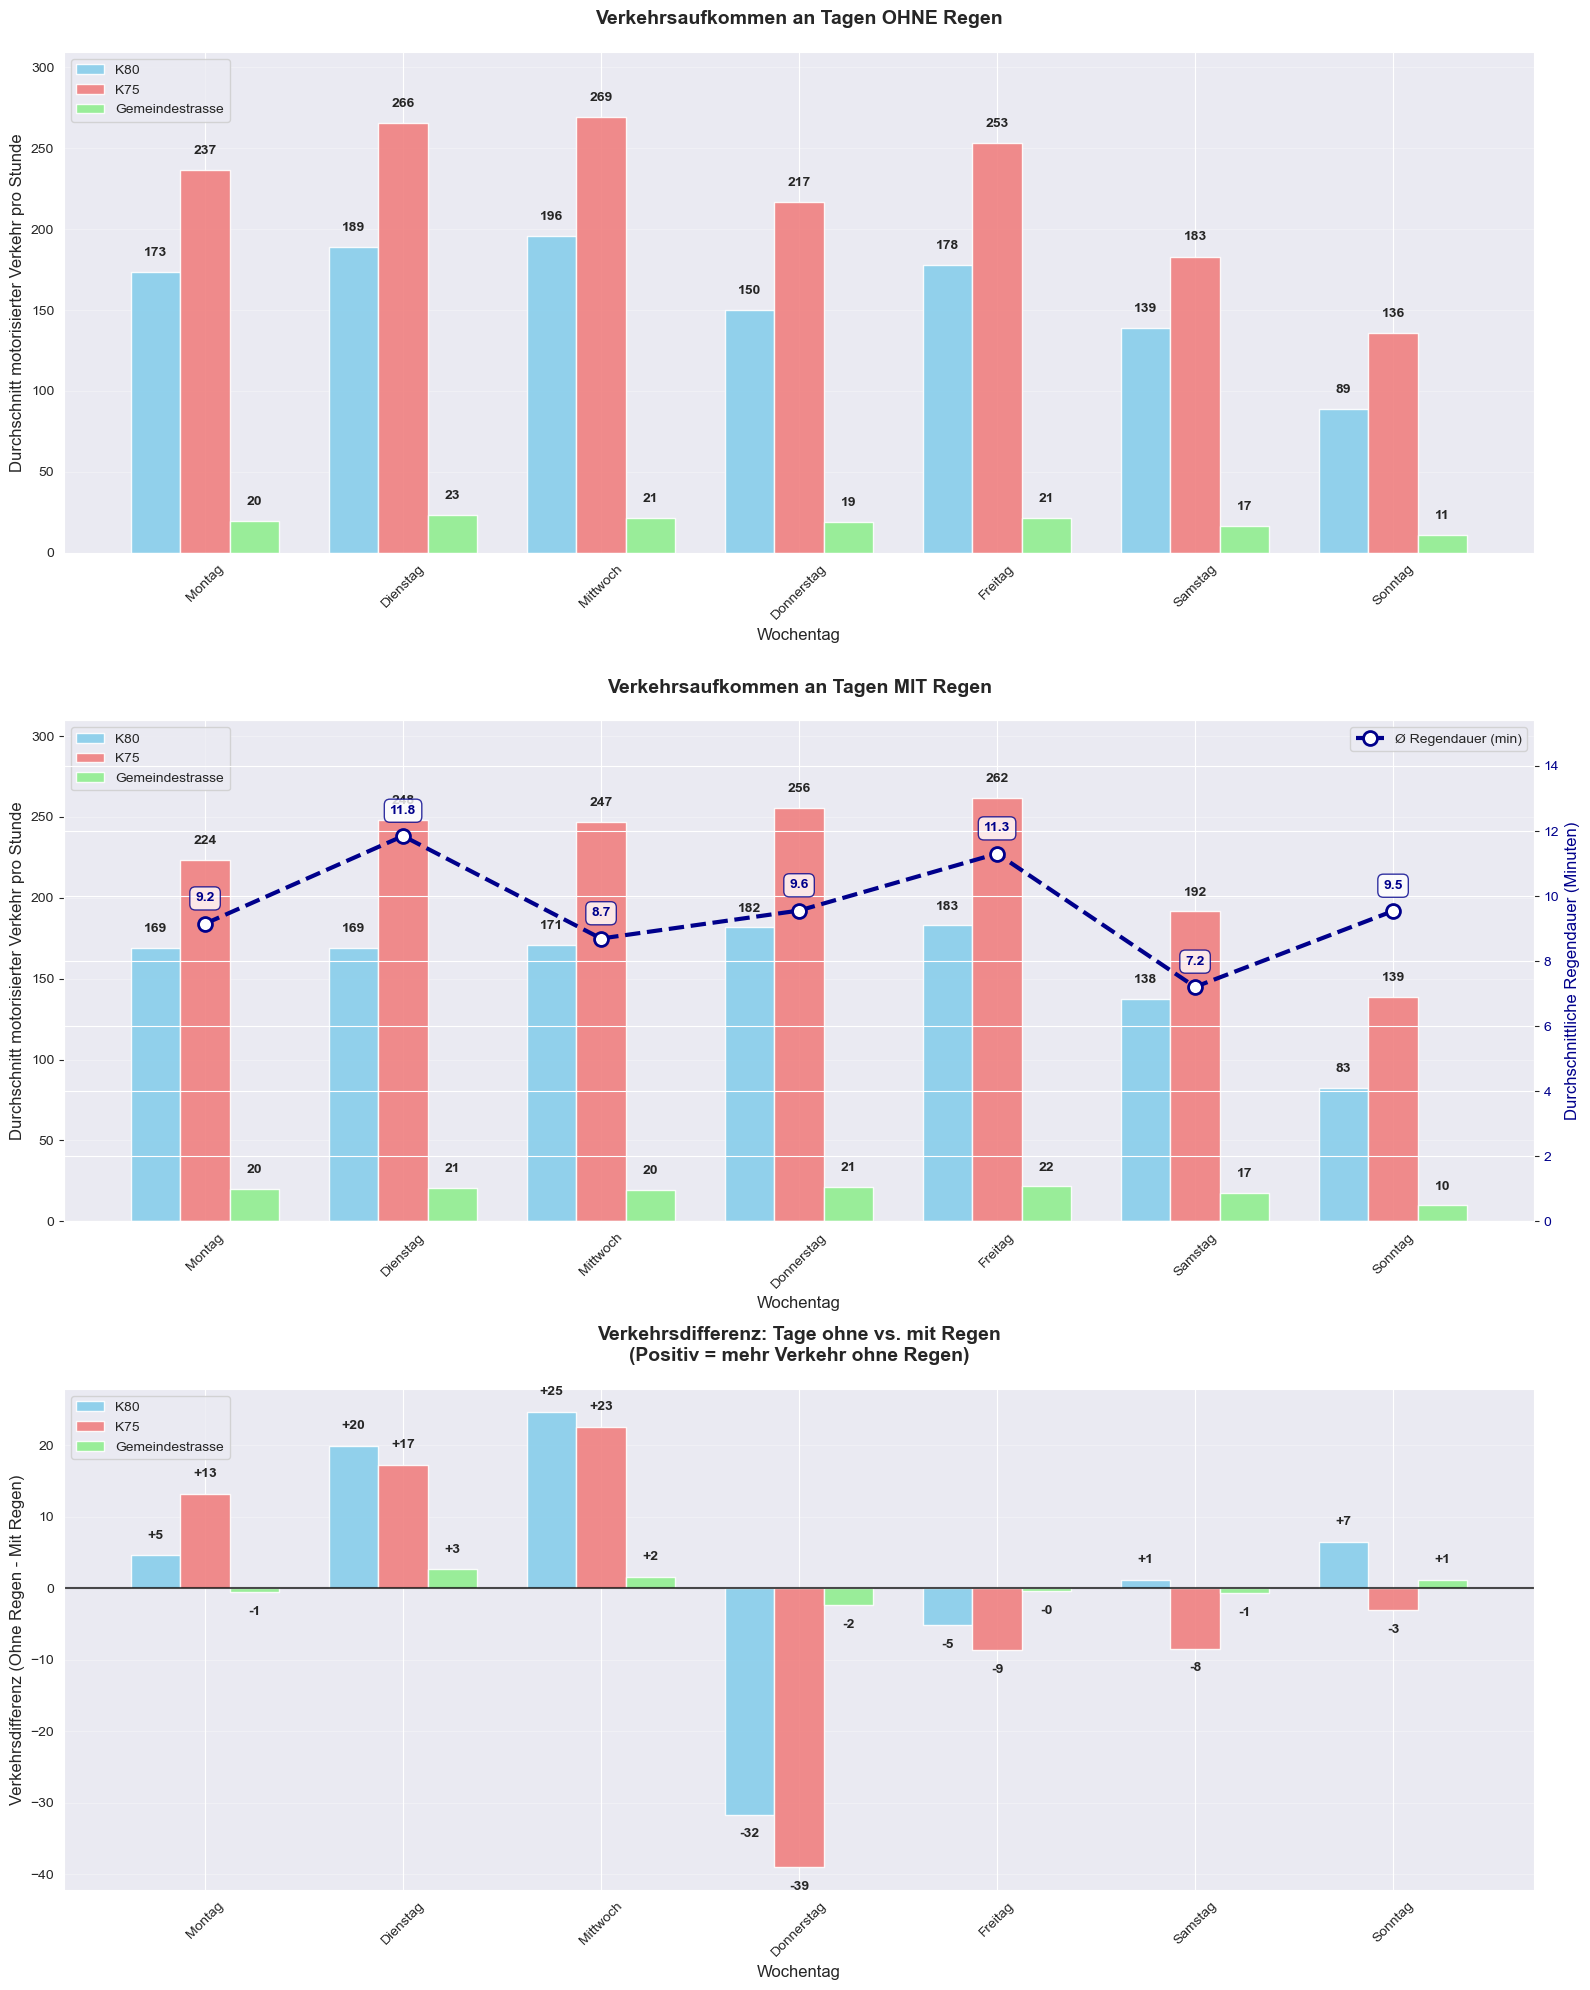


VERKEHRSDIFFERENZ-ANALYSE

Montag:
  K80: 5 Fahrzeuge mehr (2.7%)
  K75: 13 Fahrzeuge mehr (5.9%)
  Gemeindestrasse: 1 Fahrzeuge weniger (2.8%)

Dienstag:
  K80: 20 Fahrzeuge mehr (11.7%)
  K75: 17 Fahrzeuge mehr (6.9%)
  Gemeindestrasse: 3 Fahrzeuge mehr (12.7%)

Mittwoch:
  K80: 25 Fahrzeuge mehr (14.4%)
  K75: 23 Fahrzeuge mehr (9.1%)
  Gemeindestrasse: 2 Fahrzeuge mehr (8.0%)

Donnerstag:
  K80: 32 Fahrzeuge weniger (17.4%)
  K75: 39 Fahrzeuge weniger (15.2%)
  Gemeindestrasse: 2 Fahrzeuge weniger (11.3%)

Freitag:
  K80: 5 Fahrzeuge weniger (2.8%)
  K75: 9 Fahrzeuge weniger (3.3%)
  Gemeindestrasse: 0 Fahrzeuge weniger (1.9%)

Samstag:
  K80: 1 Fahrzeuge mehr (0.9%)
  K75: 8 Fahrzeuge weniger (4.4%)
  Gemeindestrasse: 1 Fahrzeuge weniger (4.0%)

Sonntag:
  K80: 7 Fahrzeuge mehr (7.9%)
  K75: 3 Fahrzeuge weniger (2.2%)
  Gemeindestrasse: 1 Fahrzeuge mehr (11.7%)


In [182]:
tage = [
    "Montag",
    "Dienstag",
    "Mittwoch",
    "Donnerstag",
    "Freitag",
    "Samstag",
    "Sonntag",
]

# Prüfen ob ist_regentag bereits existiert, sonst erstellen
if "ist_regentag" not in df_k80.columns or "datum" not in df_k80.columns:
    # Datum extrahieren und Regentage identifizieren
    datum_col = df_k80.columns[5]  # 'datum' Spalte

    df_k80["datum"] = pd.to_datetime(df_k80[datum_col]).dt.date
    df_k75["datum"] = pd.to_datetime(df_k75[datum_col]).dt.date
    df_gemeinde["datum"] = pd.to_datetime(df_gemeinde[datum_col]).dt.date

    # Tage mit Regen identifizieren (sobald es an einem Tag irgendwann regnet)
    tage_mit_regen = df_k80[df_k80["messwert"] > 0]["datum"].unique()

    # Markierung hinzufügen
    df_k80["ist_regentag"] = df_k80["datum"].isin(tage_mit_regen)
    df_k75["ist_regentag"] = df_k75["datum"].isin(tage_mit_regen)
    df_gemeinde["ist_regentag"] = df_gemeinde["datum"].isin(tage_mit_regen)

# Statistik ausgeben
tage_mit_regen = df_k80[df_k80["messwert"] > 0]["datum"].unique()
tage_ohne_regen_komplett = df_k80[~df_k80["datum"].isin(tage_mit_regen)][
    "datum"
].unique()

print(f"Anzahl Tage MIT Regen: {len(tage_mit_regen)}")
print(f"Anzahl Tage OHNE Regen: {len(tage_ohne_regen_komplett)}")
print(f"Gesamt unterschiedliche Tage: {df_k80['datum'].nunique()}")
print(
    f"\nDurchschnittliche Regendauer wenn es regnet: {df_k80[df_k80['messwert'] > 0]['messwert'].mean():.2f} Minuten"
)

# Daten für Tage OHNE Regen
df_k80_kein_regen = df_k80[~df_k80["ist_regentag"]]
df_k75_kein_regen = df_k75[~df_k75["ist_regentag"]]
df_gemeinde_kein_regen = df_gemeinde[~df_gemeinde["ist_regentag"]]

k80_kein_regen = (
    df_k80_kein_regen.groupby("wochentag", observed=False)["motorisiert_total"]
    .mean()
    .reindex(tage)
)
k75_kein_regen = (
    df_k75_kein_regen.groupby("wochentag", observed=False)["motorisiert_total"]
    .mean()
    .reindex(tage)
)
gemeinde_kein_regen = (
    df_gemeinde_kein_regen.groupby("wochentag", observed=False)[
        "motorisiert_total"
    ]
    .mean()
    .reindex(tage)
)

# Daten für Tage MIT Regen
df_k80_mit_regen = df_k80[df_k80["ist_regentag"]]
df_k75_mit_regen = df_k75[df_k75["ist_regentag"]]
df_gemeinde_mit_regen = df_gemeinde[df_gemeinde["ist_regentag"]]

k80_mit_regen = (
    df_k80_mit_regen.groupby("wochentag", observed=False)["motorisiert_total"]
    .mean()
    .reindex(tage)
)
k75_mit_regen = (
    df_k75_mit_regen.groupby("wochentag", observed=False)["motorisiert_total"]
    .mean()
    .reindex(tage)
)
gemeinde_mit_regen = (
    df_gemeinde_mit_regen.groupby("wochentag", observed=False)[
        "motorisiert_total"
    ]
    .mean()
    .reindex(tage)
)

# Durchschnittliche Regendauer pro Wochentag (nur an Regentagen)
regen_grouped = (
    df_k80_mit_regen.groupby("wochentag", observed=False)["messwert"]
    .mean()
    .reindex(tage)
)

# DataFrames erstellen
df_kein_regen_combined = pd.DataFrame(
    {
        "K80": k80_kein_regen,
        "K75": k75_kein_regen,
        "Gemeindestrasse": gemeinde_kein_regen,
    }
)

df_mit_regen_combined = pd.DataFrame(
    {
        "K80": k80_mit_regen,
        "K75": k75_mit_regen,
        "Gemeindestrasse": gemeinde_mit_regen,
    }
)

# Differenz berechnen (Ohne Regen - Mit Regen)
# Positive Werte = mehr Verkehr ohne Regen
df_differenz = df_kein_regen_combined - df_mit_regen_combined

# Drei Plots nebeneinander erstellen
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 20))

x_pos = range(len(tage))
width = 0.25

# Plot 1: Tage OHNE Regen
bars1_kein = ax1.bar(
    [x - width for x in x_pos],
    df_kein_regen_combined["K80"],
    width,
    label="K80",
    color="skyblue",
    alpha=0.9,
)
bars2_kein = ax1.bar(
    x_pos,
    df_kein_regen_combined["K75"],
    width,
    label="K75",
    color="lightcoral",
    alpha=0.9,
)
bars3_kein = ax1.bar(
    [x + width for x in x_pos],
    df_kein_regen_combined["Gemeindestrasse"],
    width,
    label="Gemeindestrasse",
    color="lightgreen",
    alpha=0.9,
)

ax1.set_xlabel("Wochentag", fontsize=12)
ax1.set_ylabel("Durchschnitt motorisierter Verkehr pro Stunde", fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(tage, rotation=45)
ax1.set_title(
    "Verkehrsaufkommen an Tagen OHNE Regen",
    fontsize=14,
    pad=20,
    fontweight="bold",
)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(axis="y", alpha=0.3)

# Labels auf Balken - Plot 1
max_verkehr_kein = df_kein_regen_combined.max().max()
offset_kein = max_verkehr_kein * 0.03

for bars in [bars1_kein, bars2_kein, bars3_kein]:
    for bar in bars:
        height = bar.get_height()
        if height > 0 and not pd.isna(height):
            ax1.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + offset_kein,
                f"{height:.0f}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

# Plot 2: Tage MIT Regen
bars1_mit = ax2.bar(
    [x - width for x in x_pos],
    df_mit_regen_combined["K80"],
    width,
    label="K80",
    color="skyblue",
    alpha=0.9,
)
bars2_mit = ax2.bar(
    x_pos,
    df_mit_regen_combined["K75"],
    width,
    label="K75",
    color="lightcoral",
    alpha=0.9,
)
bars3_mit = ax2.bar(
    [x + width for x in x_pos],
    df_mit_regen_combined["Gemeindestrasse"],
    width,
    label="Gemeindestrasse",
    color="lightgreen",
    alpha=0.9,
)

ax2.set_xlabel("Wochentag", fontsize=12)
ax2.set_ylabel("Durchschnitt motorisierter Verkehr pro Stunde", fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(tage, rotation=45)
ax2.set_title(
    "Verkehrsaufkommen an Tagen MIT Regen",
    fontsize=14,
    pad=20,
    fontweight="bold",
)
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(axis="y", alpha=0.3)

# Labels auf Balken - Plot 2
max_verkehr_mit = df_mit_regen_combined.max().max()
offset_mit = max_verkehr_mit * 0.03

for bars in [bars1_mit, bars2_mit, bars3_mit]:
    for bar in bars:
        height = bar.get_height()
        if height > 0 and not pd.isna(height):
            ax2.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + offset_mit,
                f"{height:.0f}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

# Zweite y-Achse für Regenmenge in Plot 2
ax2_regen = ax2.twinx()
line = ax2_regen.plot(
    x_pos,
    regen_grouped.values,
    color="darkblue",
    marker="o",
    linewidth=3,
    markersize=10,
    label="Ø Regendauer (min)",
    linestyle="--",
    markerfacecolor="white",
    markeredgewidth=2,
)
ax2_regen.set_ylabel(
    "Durchschnittliche Regendauer (Minuten)", fontsize=12, color="darkblue"
)
ax2_regen.tick_params(axis="y", labelcolor="darkblue")

# y-Achse für Regen anpassen
y_max_regen = regen_grouped.max() * 1.3
ax2_regen.set_ylim(0, y_max_regen)

# Werte auf der Linie anzeigen
for i, v in enumerate(regen_grouped.values):
    if not pd.isna(v):
        ax2_regen.text(
            i,
            v + regen_grouped.max() * 0.05,
            f"{v:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
            color="darkblue",
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor="white",
                edgecolor="darkblue",
                alpha=0.8,
            ),
        )

ax2_regen.legend(loc="upper right", fontsize=10)

# Plot 3: DIFFERENZ (Ohne Regen - Mit Regen)
# Positive Werte = mehr Verkehr ohne Regen, Negative Werte = mehr Verkehr mit Regen
bars1_diff = ax3.bar(
    [x - width for x in x_pos],
    df_differenz["K80"],
    width,
    label="K80",
    color="skyblue",
    alpha=0.9,
)
bars2_diff = ax3.bar(
    x_pos,
    df_differenz["K75"],
    width,
    label="K75",
    color="lightcoral",
    alpha=0.9,
)
bars3_diff = ax3.bar(
    [x + width for x in x_pos],
    df_differenz["Gemeindestrasse"],
    width,
    label="Gemeindestrasse",
    color="lightgreen",
    alpha=0.9,
)

ax3.axhline(y=0, color="black", linestyle="-", linewidth=1.5, alpha=0.7)
ax3.set_xlabel("Wochentag", fontsize=12)
ax3.set_ylabel("Verkehrsdifferenz (Ohne Regen - Mit Regen)", fontsize=12)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(tage, rotation=45)
ax3.set_title(
    "Verkehrsdifferenz: Tage ohne vs. mit Regen\n(Positiv = mehr Verkehr ohne Regen)",
    fontsize=14,
    pad=20,
    fontweight="bold",
)
ax3.legend(loc="upper left", fontsize=10)
ax3.grid(axis="y", alpha=0.3)

# Labels auf Balken - Plot 3 (mit +/- Vorzeichen)
max_diff = max(abs(df_differenz.max().max()), abs(df_differenz.min().min()))
offset_diff = max_diff * 0.05

for bars in [bars1_diff, bars2_diff, bars3_diff]:
    for bar in bars:
        height = bar.get_height()
        if not pd.isna(height) and height != 0:
            # Vorzeichen hinzufügen
            label = f"+{height:.0f}" if height > 0 else f"{height:.0f}"
            # Position je nach positiv/negativ
            va = "bottom" if height > 0 else "top"
            offset = offset_diff if height > 0 else -offset_diff

            ax3.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + offset,
                label,
                ha="center",
                va=va,
                fontsize=10,
                fontweight="bold",
            )

# Gleiche y-Achsen-Skalierung für Plot 1 und 2
y_max = (
    max(df_kein_regen_combined.max().max(), df_mit_regen_combined.max().max())
    * 1.15
)
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

# Zusätzliche Statistik ausgeben
print("\n" + "=" * 60)
print("VERKEHRSDIFFERENZ-ANALYSE")
print("=" * 60)
for tag in tage:
    print(f"\n{tag}:")
    for strasse in ["K80", "K75", "Gemeindestrasse"]:
        diff = df_differenz.loc[tag, strasse]
        if not pd.isna(diff):
            prozent = (
                (diff / df_mit_regen_combined.loc[tag, strasse] * 100)
                if df_mit_regen_combined.loc[tag, strasse] != 0
                else 0
            )
            richtung = "mehr" if diff > 0 else "weniger"
            print(
                f"  {strasse}: {abs(diff):.0f} Fahrzeuge {richtung} ({abs(prozent):.1f}%)"
            )

An den Durchschnittswerten ist erkennbar, dass das Verkehrsaufkommen am Wochenende deutlich niedriger ist als unter der Woche. Das ist naheliegend, da am Wochenende deutlich weniger Menschen zur Arbeit fahren. Um diesen Unterschied zusätzlich zu veranschaulichen, stellen wir im Folgenden das Verkehrsaufkommen im zeitlichen Verlauf dar.

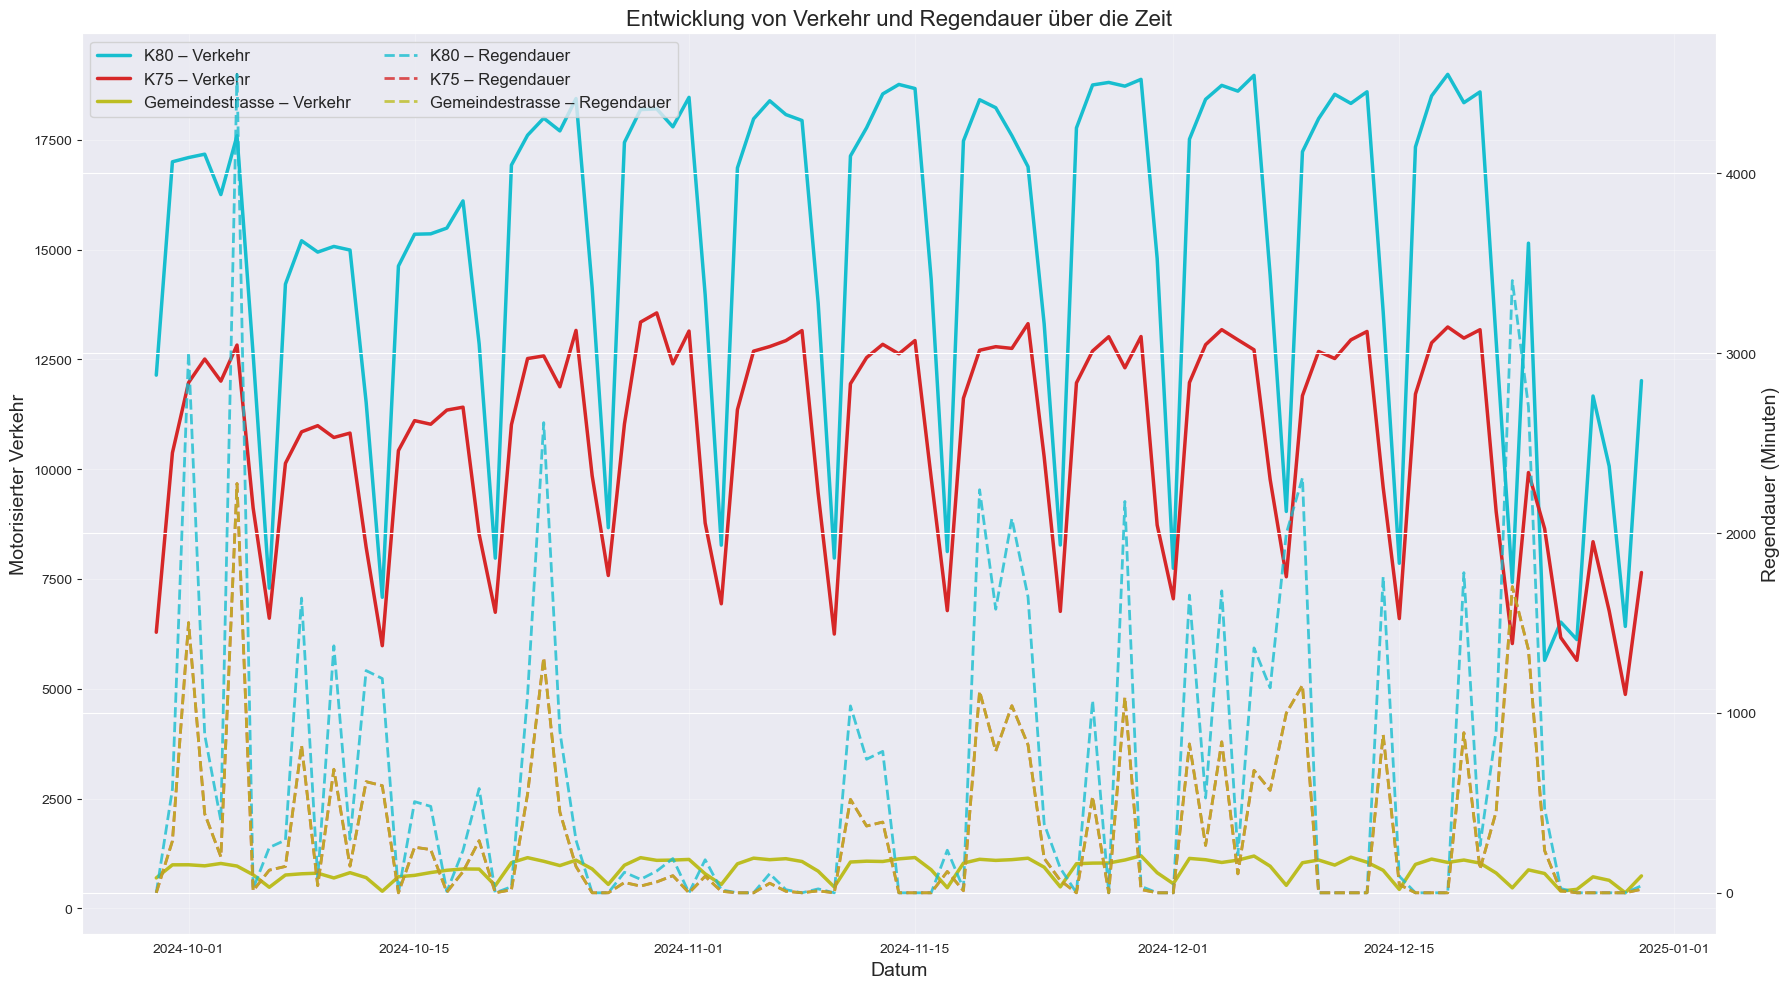

In [183]:
# plot over time
# Funktion: Tageswerte für Verkehr + Regen aggregieren
def prepare_daily(df, label):
    daily = (
        df.groupby("datum")
        .agg(
            {
                "motorisiert_total": "sum",
                "messwert": "sum",  # Regendauer pro Tag aufsummieren
            }
        )
        .reset_index()
    )
    daily["typ"] = label
    return daily


# Daten vorbereiten
daily_k80 = prepare_daily(df_k80, "K80")
daily_k75 = prepare_daily(df_k75, "K75")
daily_gem = prepare_daily(df_gemeinde, "Gemeindestrasse")

# Alles zusammenführen
daily_all = pd.concat([daily_k80, daily_k75, daily_gem], ignore_index=True)

# Plot mit zwei Y-Achsen
fig, ax1 = plt.subplots(figsize=(18, 10))

colors = {"K80": "tab:cyan", "K75": "tab:red", "Gemeindestrasse": "tab:olive"}

# Erste Y-Achse: Verkehr (durchgezogene Linien)
for typ in daily_all["typ"].unique():
    subset = daily_all[daily_all["typ"] == typ]
    ax1.plot(
        subset["datum"],
        subset["motorisiert_total"],
        label=f"{typ} – Verkehr",
        linewidth=2.5,
        color=colors[typ],
    )

ax1.set_xlabel("Datum", fontsize=14)
ax1.set_ylabel("Motorisierter Verkehr", fontsize=14)
ax1.tick_params(axis="y")
ax1.grid(alpha=0.3)

# Zweite Y-Achse: Regendauer (gestrichelte Linien)
ax2 = ax1.twinx()

for typ in daily_all["typ"].unique():
    subset = daily_all[daily_all["typ"] == typ]
    ax2.plot(
        subset["datum"],
        subset["messwert"],
        label=f"{typ} – Regendauer",
        linewidth=2.0,
        linestyle="--",
        color=colors[typ],
        alpha=0.8,
    )

ax2.set_ylabel("Regendauer (Minuten)", fontsize=14)
ax2.tick_params(axis="y")

# Legenden kombinieren
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2, fontsize=12, ncol=2, loc="upper left"
)

plt.title("Entwicklung von Verkehr und Regendauer über die Zeit", fontsize=16)
plt.tight_layout()

plt.show()

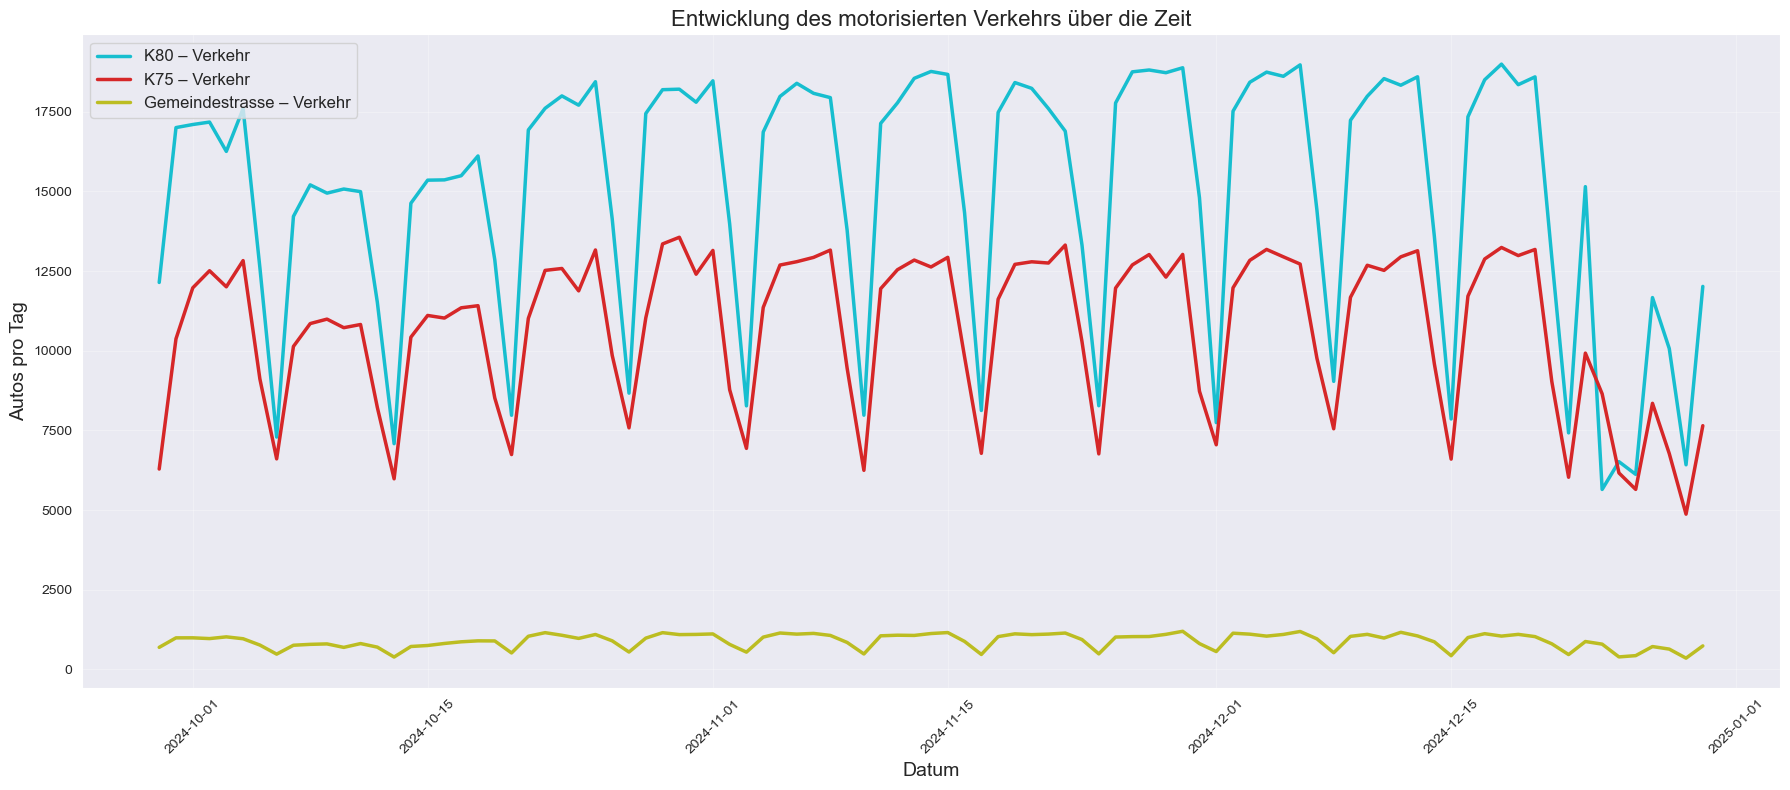

In [184]:
plt.figure(figsize=(18, 8))

for typ in daily_all["typ"].unique():
    subset = daily_all[daily_all["typ"] == typ]
    plt.plot(
        subset["datum"],
        subset["motorisiert_total"],
        label=f"{typ} – Verkehr",
        linewidth=2.5,
        color=colors[typ],
    )

plt.title("Entwicklung des motorisierten Verkehrs über die Zeit", fontsize=16)
plt.xlabel("Datum", fontsize=14)
plt.ylabel("Autos pro Tag", fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc="upper left")
plt.tight_layout()
plt.show()

Auffällig ist, dass im Oktober sowie gegen Ende des Jahres ein deutlicher Rückgang des Verkehrsaufkommens erkennbar ist. Eine Recherche ergab, dass in diesen Zeiträumen (7.10.2024–20.10.2024 und 23.12.2024–5.1.2025) Schulferien stattfanden, was den Rückgang erklärt.

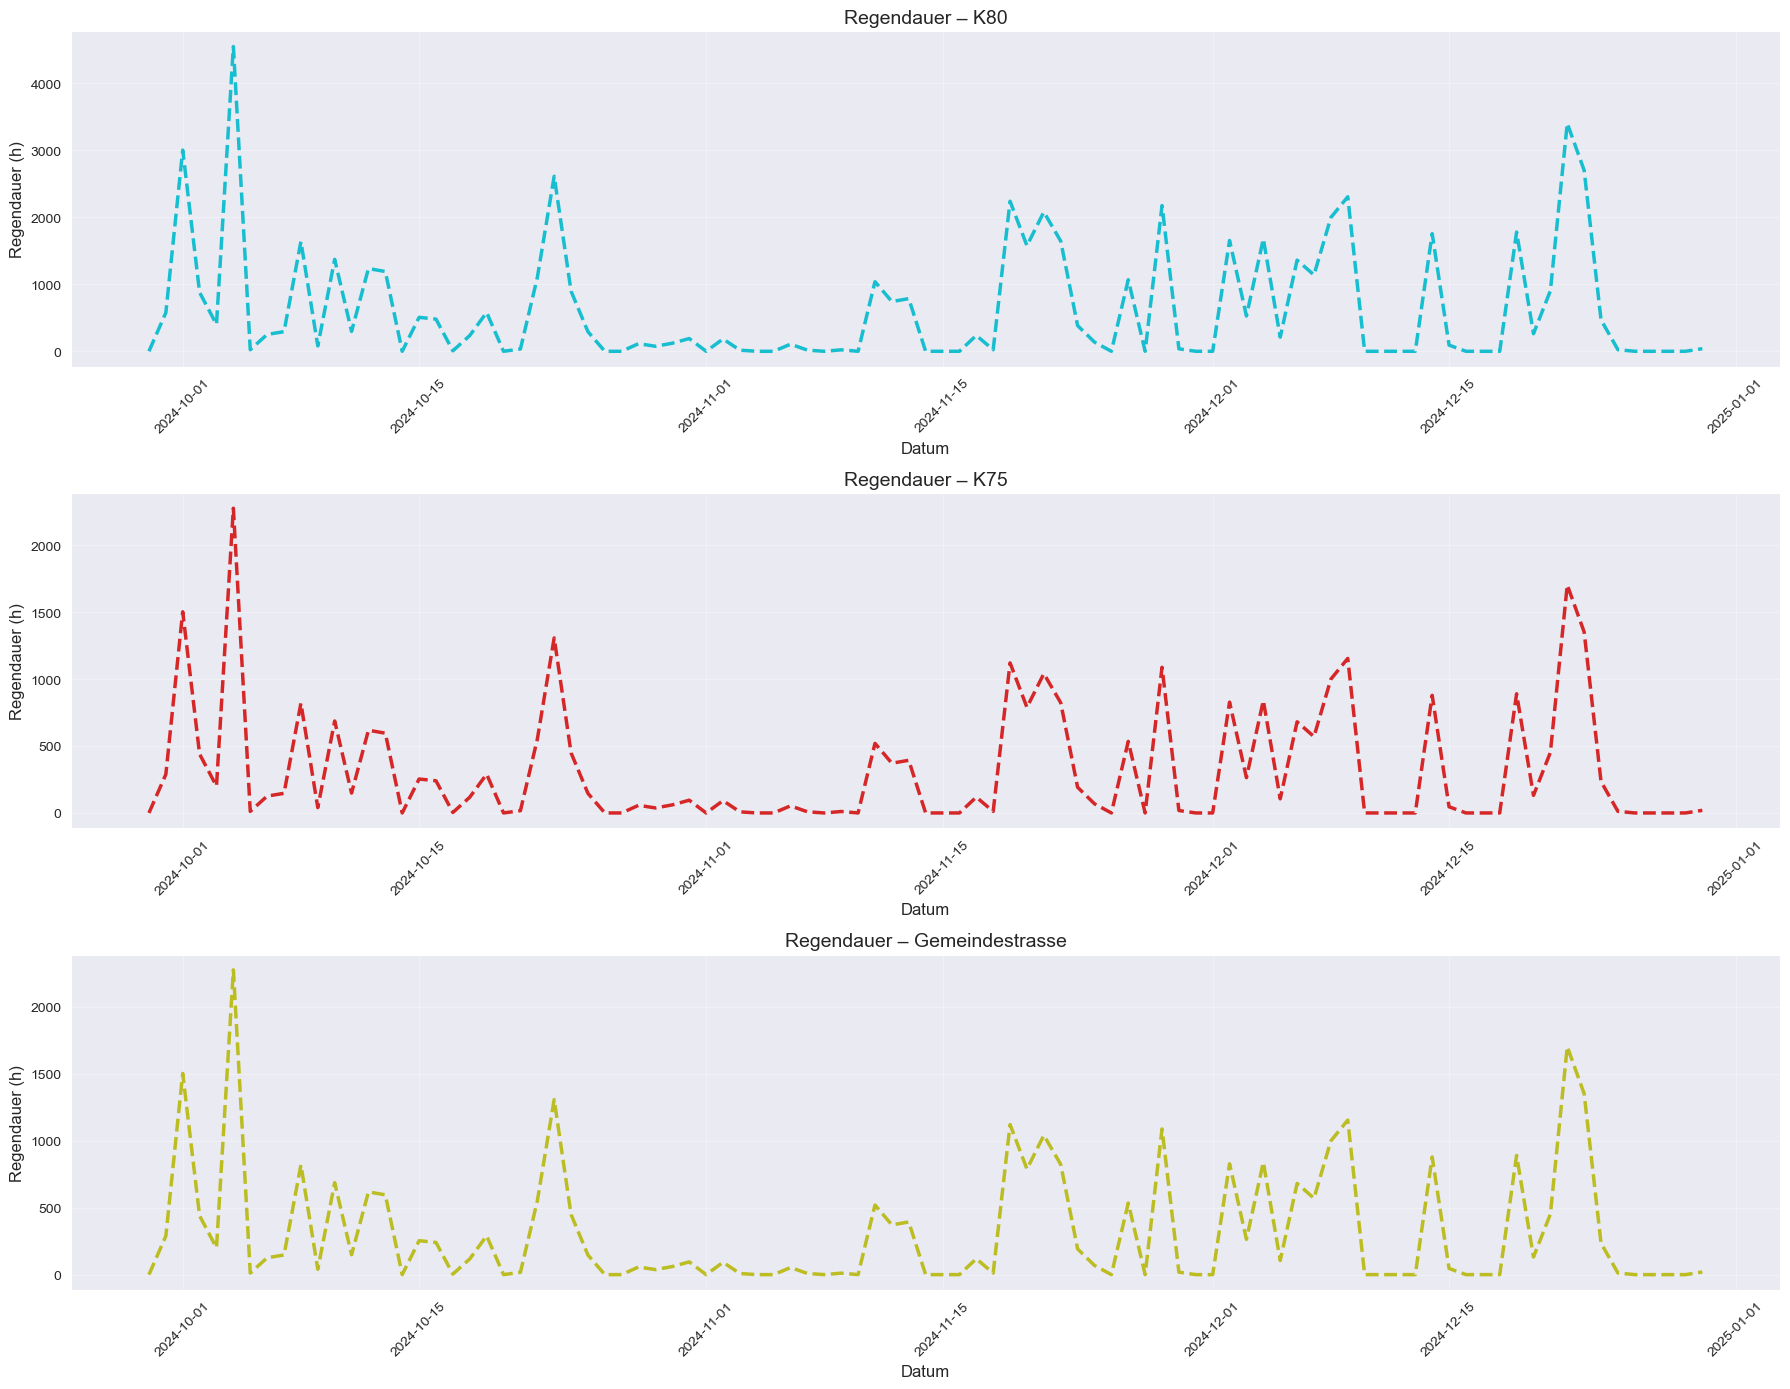

In [185]:
# Reihenfolge sicherstellen
typen = ["K80", "K75", "Gemeindestrasse"]

# Subplots erstellen OHNE sharex=True
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

for ax, typ in zip(axes, typen):
    subset = daily_all[daily_all["typ"] == typ]

    ax.plot(
        subset["datum"],
        subset["messwert"],
        linestyle="--",
        linewidth=2.5,
        color=colors[typ],
    )

    ax.set_title(f"Regendauer – {typ}", fontsize=14)
    ax.set_ylabel("Regendauer (h)", fontsize=12)
    ax.set_xlabel("Datum", fontsize=12)  # X-Achse für jeden Plot
    ax.grid(alpha=0.3)
    ax.tick_params(axis="x", rotation=45)  # Rotation für jeden Plot

plt.tight_layout()
plt.show()

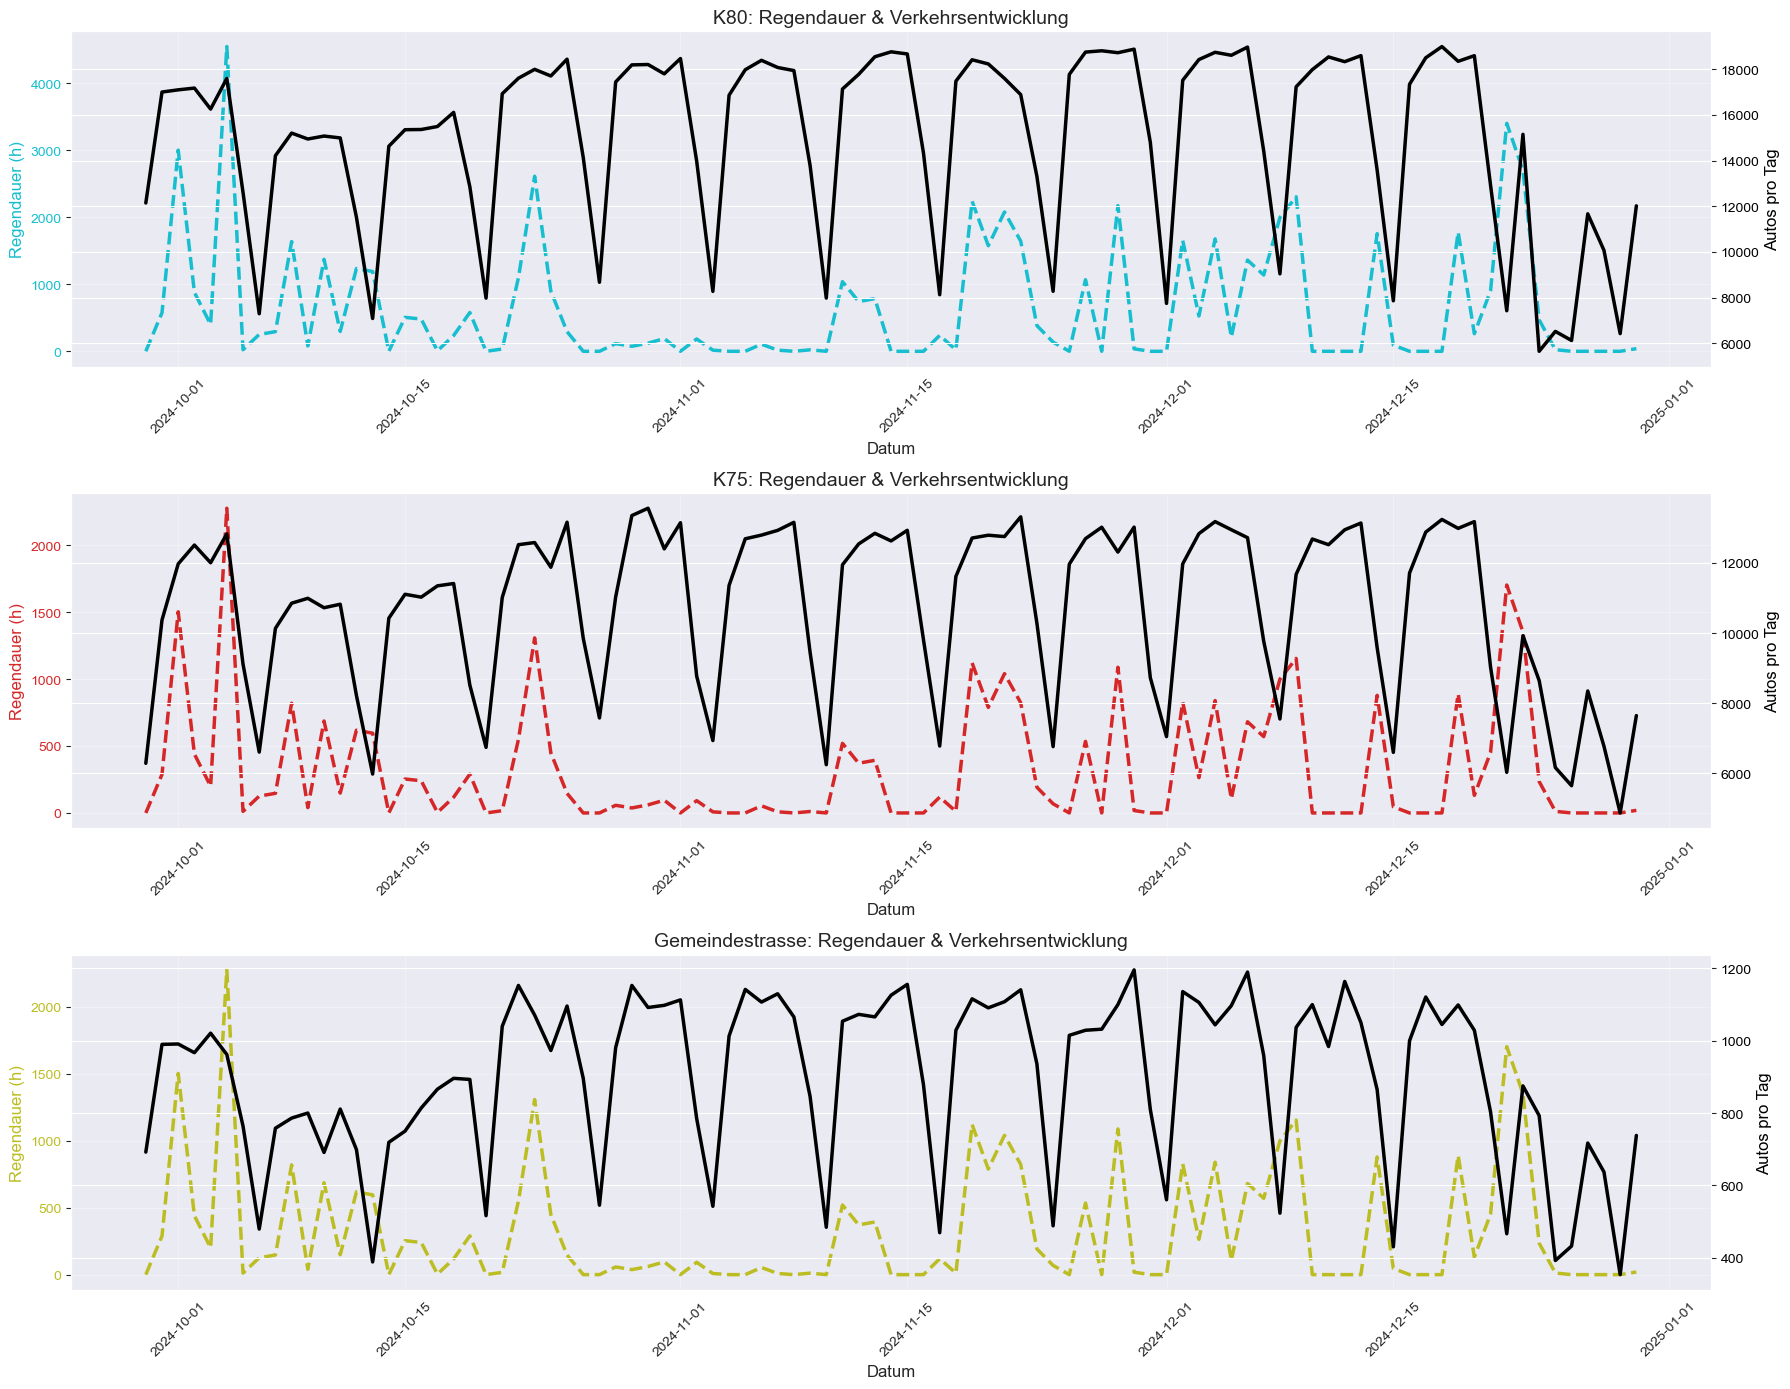

In [186]:
# Reihenfolge der Strassentypen sicherstellen
typen = ["K80", "K75", "Gemeindestrasse"]

# Figure anlegen: 3 Zeilen, 1 Spalte
fig, axes = plt.subplots(3, 1, figsize=(18, 14))

for ax, typ in zip(axes, typen):
    # Subset für diese Strasse
    subset = daily_all[daily_all["typ"] == typ]

    # ---------------------------------------------------------
    #   1) Regendauer auf linker Y-Achse
    # ---------------------------------------------------------
    ax.plot(
        subset["datum"],
        subset["messwert"],  # Regendauer in Stunden
        linestyle="--",
        linewidth=2.5,
        color=colors[typ],
        label="Regendauer",
    )

    ax.set_ylabel("Regendauer (h)", fontsize=12, color=colors[typ])
    ax.tick_params(axis="y", labelcolor=colors[typ])

    # ---------------------------------------------------------
    #   2) Verkehrsdaten auf rechter Y-Achse
    # ---------------------------------------------------------
    ax2 = ax.twinx()

    ax2.plot(
        subset["datum"],
        subset["motorisiert_total"],  # Autos pro Tag
        linewidth=2.5,
        color="black",
        label="Verkehr",
    )

    ax2.set_ylabel("Autos pro Tag", fontsize=12, color="black")
    ax2.tick_params(axis="y", labelcolor="black")

    # ---------------------------------------------------------
    #   Layout & Achsenbeschriftung
    # ---------------------------------------------------------
    ax.set_title(f"{typ}: Regendauer & Verkehrsentwicklung", fontsize=14)
    ax.set_xlabel("Datum", fontsize=12)
    ax.grid(alpha=0.3)
    ax.tick_params(axis="x", rotation=45)

# Optimiertes Layout
plt.tight_layout()
plt.show()

## Korrelation von Fahrzeuge und Regendauer

Korrelation zwischen Regendauer und Verkehr (K80): -0.024
Korrelation zwischen Regendauer und Verkehr (K75): -0.019
Korrelation zwischen Regendauer und Verkehr (Gemeindestrasse): -0.016


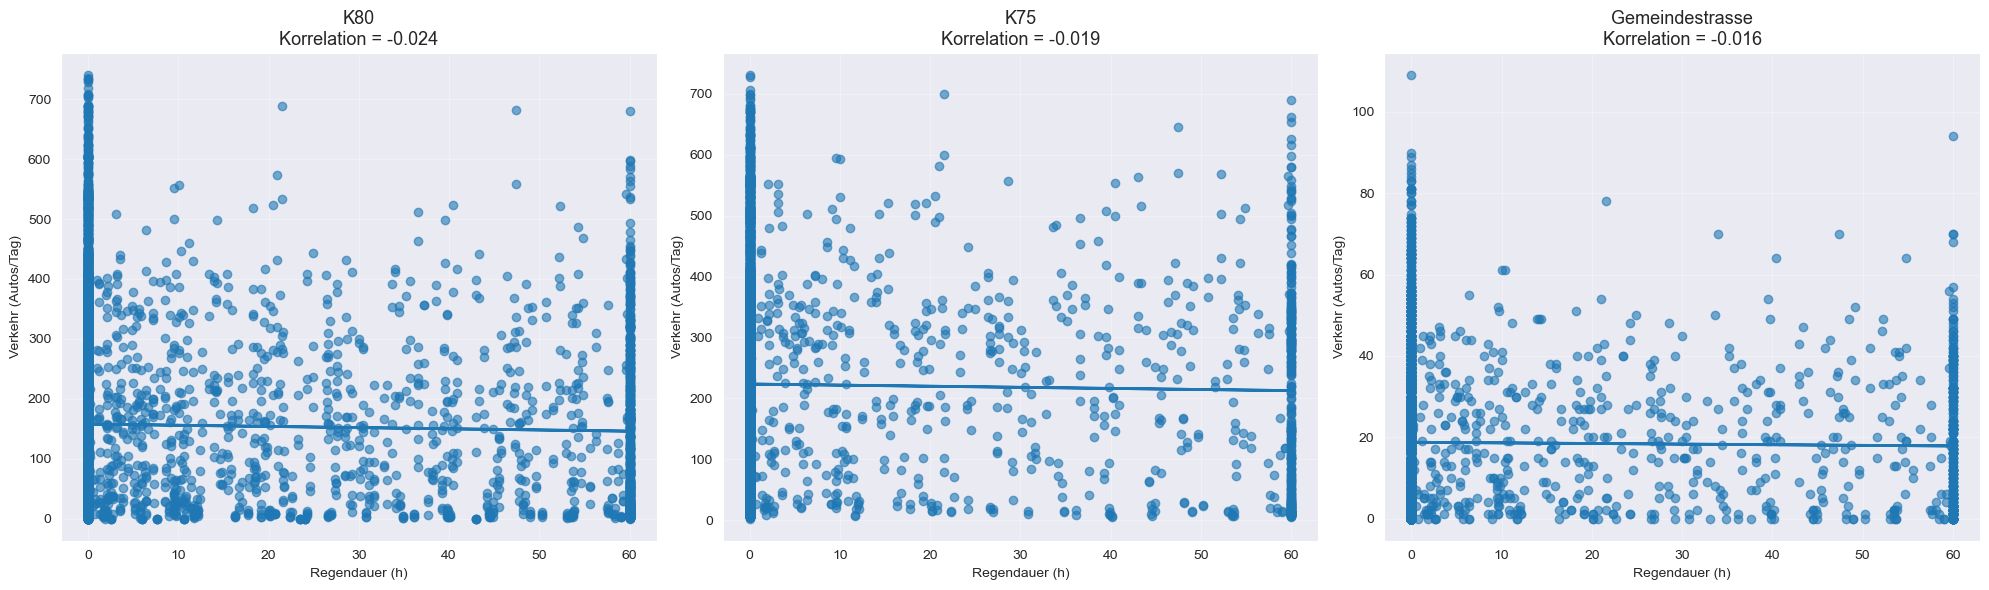

In [187]:
def berechne_korrelation(df, name):
    corr = df["motorisiert_total"].corr(df["messwert"])
    print(f"Korrelation zwischen Regendauer und Verkehr ({name}): {corr:.3f}")
    return corr


corr_k80 = berechne_korrelation(df_k80, "K80")
corr_k75 = berechne_korrelation(df_k75, "K75")
corr_gem = berechne_korrelation(df_gemeinde, "Gemeindestrasse")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

datasets = [
    ("K80", df_k80, corr_k80),
    ("K75", df_k75, corr_k75),
    ("Gemeindestrasse", df_gemeinde, corr_gem),
]

for ax, (name, df, corr) in zip(axes, datasets):

    # Scatterplot
    ax.scatter(df["messwert"], df["motorisiert_total"], alpha=0.6)

    # Regression line (optional)
    x = df["messwert"]
    y = df["motorisiert_total"]

    if len(df) > 1:
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m * x + b, linewidth=2)

    ax.set_title(f"{name}\nKorrelation = {corr:.3f}", fontsize=13)
    ax.set_xlabel("Regendauer (h)")
    ax.set_ylabel("Verkehr (Autos/Tag)")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Beim berechnen der Korrelation wird für die Anzahl Fahrzeuge und die Regendauer, keine signifikante Korrelation sichtbar.

## Vergleich Stosszeiten im Bezug auf Regen

Um zu schauen ob ein Zusammenhang zwischen dem Verkehr während den Stosszeiten und der Regendauer besteht, muss zuerst geschaut werden, wo genau die Stosszeiten sind. 

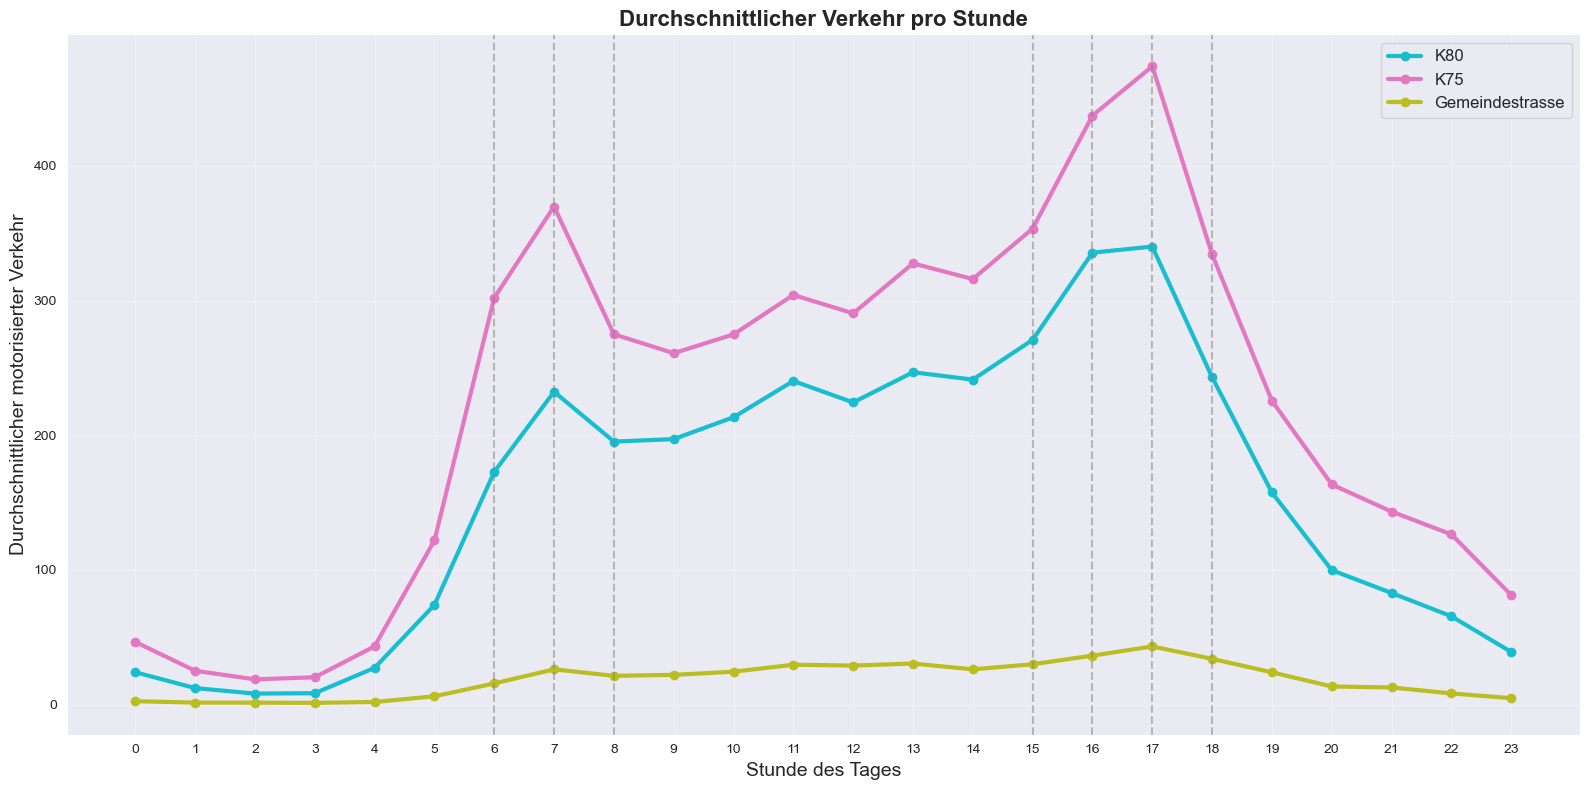


VERKEHRSSPITZEN PRO STRASSE

K80:
----------------------------------------
  17:00 Uhr → 340 Fahrzeuge
  16:00 Uhr → 336 Fahrzeuge
  15:00 Uhr → 271 Fahrzeuge
  13:00 Uhr → 247 Fahrzeuge
  18:00 Uhr → 243 Fahrzeuge

K75:
----------------------------------------
  17:00 Uhr → 474 Fahrzeuge
  16:00 Uhr → 437 Fahrzeuge
  07:00 Uhr → 370 Fahrzeuge
  15:00 Uhr → 353 Fahrzeuge
  18:00 Uhr → 334 Fahrzeuge

Gemeindestrasse:
----------------------------------------
  17:00 Uhr → 43 Fahrzeuge
  16:00 Uhr → 36 Fahrzeuge
  18:00 Uhr → 34 Fahrzeuge
  13:00 Uhr → 31 Fahrzeuge
  15:00 Uhr → 30 Fahrzeuge


In [188]:
# Funktion: Durchschnittlichen Verkehr pro Stunde berechnen
def verkehr_pro_stunde(df, name):
    df = df.copy()
    df["Stunde"] = pd.to_datetime(df["zeit_von"]).dt.hour

    # Durchschnitt pro Stunde berechnen
    stunden_avg = (
        df.groupby("Stunde")["motorisiert_total"].mean().reset_index()
    )
    stunden_avg["Strasse"] = name

    return stunden_avg


# Daten für alle drei Straen vorbereiten
stunden_k80 = verkehr_pro_stunde(df_k80, "K80")
stunden_k75 = verkehr_pro_stunde(df_k75, "K75")
stunden_gem = verkehr_pro_stunde(df_gemeinde, "Gemeindestrasse")

# Zusammenführen
stunden_all = pd.concat(
    [stunden_k80, stunden_k75, stunden_gem], ignore_index=True
)

# Plot erstellen
plt.figure(figsize=(16, 8))

colors = {"K80": "tab:cyan", "K75": "tab:pink", "Gemeindestrasse": "tab:olive"}

for strasse in stunden_all["Strasse"].unique():
    subset = stunden_all[stunden_all["Strasse"] == strasse]
    plt.plot(
        subset["Stunde"],
        subset["motorisiert_total"],
        label=strasse,
        linewidth=3,
        color=colors[strasse],
        marker="o",
        markersize=6,
    )

# Rushhour-Zeiten hervorheben
rushhour = [6, 7, 8, 15, 16, 17, 18]
for stunde in rushhour:
    plt.axvline(
        x=stunde, color="gray", linestyle="--", alpha=0.5, linewidth=1.5
    )

plt.title(
    "Durchschnittlicher Verkehr pro Stunde", fontsize=16, fontweight="bold"
)
plt.xlabel("Stunde des Tages", fontsize=14)
plt.ylabel("Durchschnittlicher motorisierter Verkehr", fontsize=14)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# Optional: Detaillierte Statistik ausgeben
print("\n" + "=" * 60)
print("VERKEHRSSPITZEN PRO STRASSE")
print("=" * 60)

for strasse in ["K80", "K75", "Gemeindestrasse"]:
    subset = stunden_all[stunden_all["Strasse"] == strasse]

    # Top 5 verkehrsreichste Stunden
    top5 = subset.nlargest(5, "motorisiert_total")

    print(f"\n{strasse}:")
    print("-" * 40)
    for _, row in top5.iterrows():
        print(
            f"  {int(row['Stunde']):02d}:00 Uhr → {row['motorisiert_total']:.0f} Fahrzeuge"
        )


Rushhour Vergleich – K80
False = trockene Stunden   |   True = Regenstunden
Regentag
False    254.420664
True     262.270642
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 7.85 (+3.09%)

Rushhour Vergleich – K75
False = trockene Stunden   |   True = Regenstunden
Regentag
False    359.970480
True     382.334862
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 22.36 (+6.21%)

Rushhour Vergleich – Gemeindestrasse
False = trockene Stunden   |   True = Regenstunden
Regentag
False    29.277675
True     31.087156
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 1.81 (+6.18%)


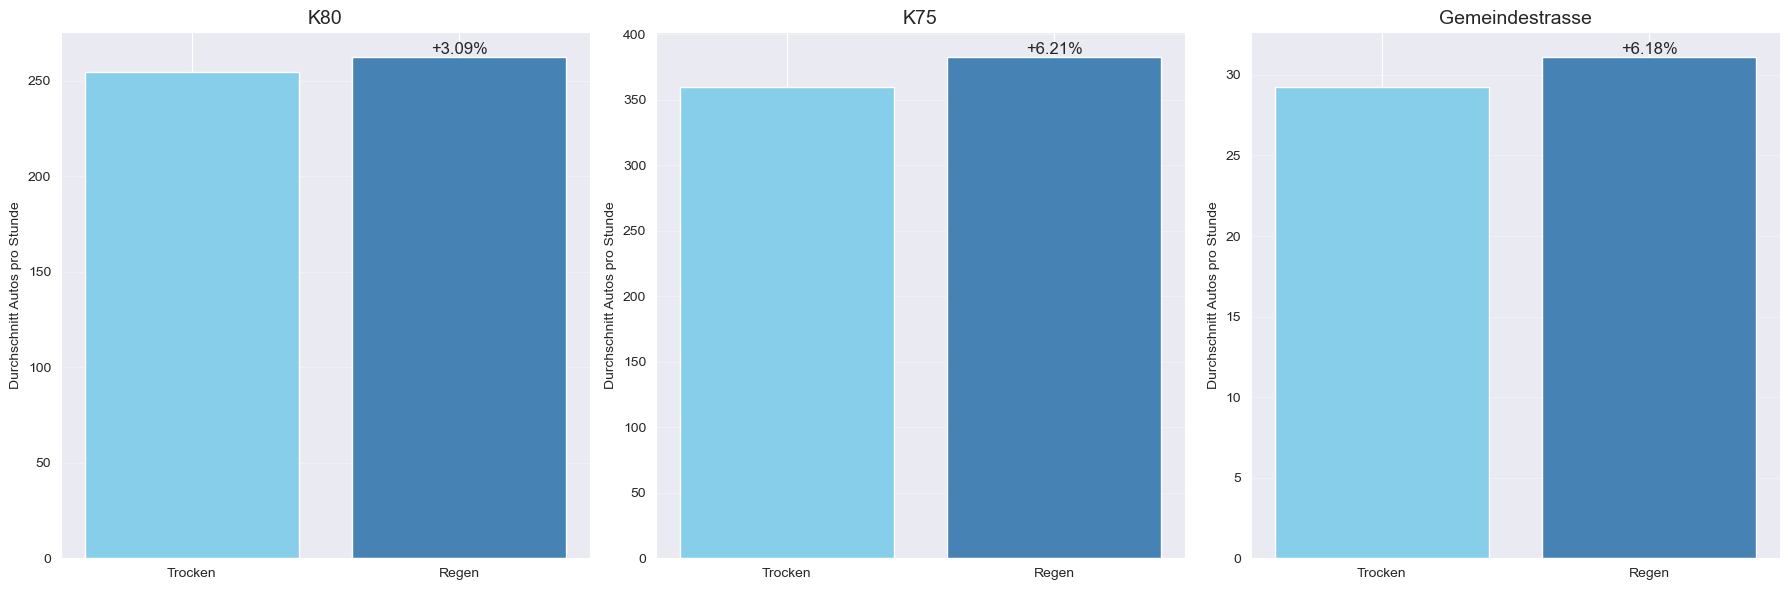

In [189]:
# Rushhour definieren
rushhour = [6, 7, 8, 15, 16, 17, 18]


def rushhour_vergleich(df, name, ax=None):
    df = df.copy()
    df["Stunde"] = pd.to_datetime(df["zeit_von"]).dt.hour
    df_rush = df[df["Stunde"].isin(rushhour)]
    df_rush["Regentag"] = df_rush["messwert"] > 0

    gruppen = df_rush.groupby("Regentag")["motorisiert_total"].mean()

    # Konsolen-Output
    print(f"\nRushhour Vergleich – {name}")
    print("==========================================")
    print("False = trockene Stunden   |   True = Regenstunden")
    print(gruppen)

    if False in gruppen.index and True in gruppen.index:
        diff = gruppen[True] - gruppen[False]
        prozent = (diff / gruppen[False]) * 100
        print(f"Unterschied (Regen - Trocken): {diff:.2f} ({prozent:+.2f}%)")
    else:
        print("Keine ausreichenden Daten für beide Gruppen.")

    # Balkendiagramm, falls Achse übergeben
    if ax is not None:
        ax.bar(
            ["Trocken", "Regen"],
            gruppen.reindex([False, True], fill_value=0),
            color=["skyblue", "steelblue"],
        )
        ax.set_title(name, fontsize=14)
        ax.set_ylabel("Durchschnitt Autos pro Stunde")
        ax.grid(alpha=0.3, axis="y")

        # Prozentuale Veränderung annotieren
        if False in gruppen.index and True in gruppen.index:
            ax.text(
                1,
                gruppen[True],
                f"{prozent:+.2f}%",
                ha="center",
                va="bottom",
                fontsize=12,
            )


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

rushhour_vergleich(df_k80, "K80", ax=axes[0])
rushhour_vergleich(df_k75, "K75", ax=axes[1])
rushhour_vergleich(df_gemeinde, "Gemeindestrasse", ax=axes[2])

plt.tight_layout()
plt.show()


K80 – Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    254.420664
True     262.270642
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 7.85 (+3.09%)

K75 – Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    359.970480
True     382.334862
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 22.36 (+6.21%)

Gemeindestrasse – Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    29.277675
True     31.087156
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): 1.81 (+6.18%)


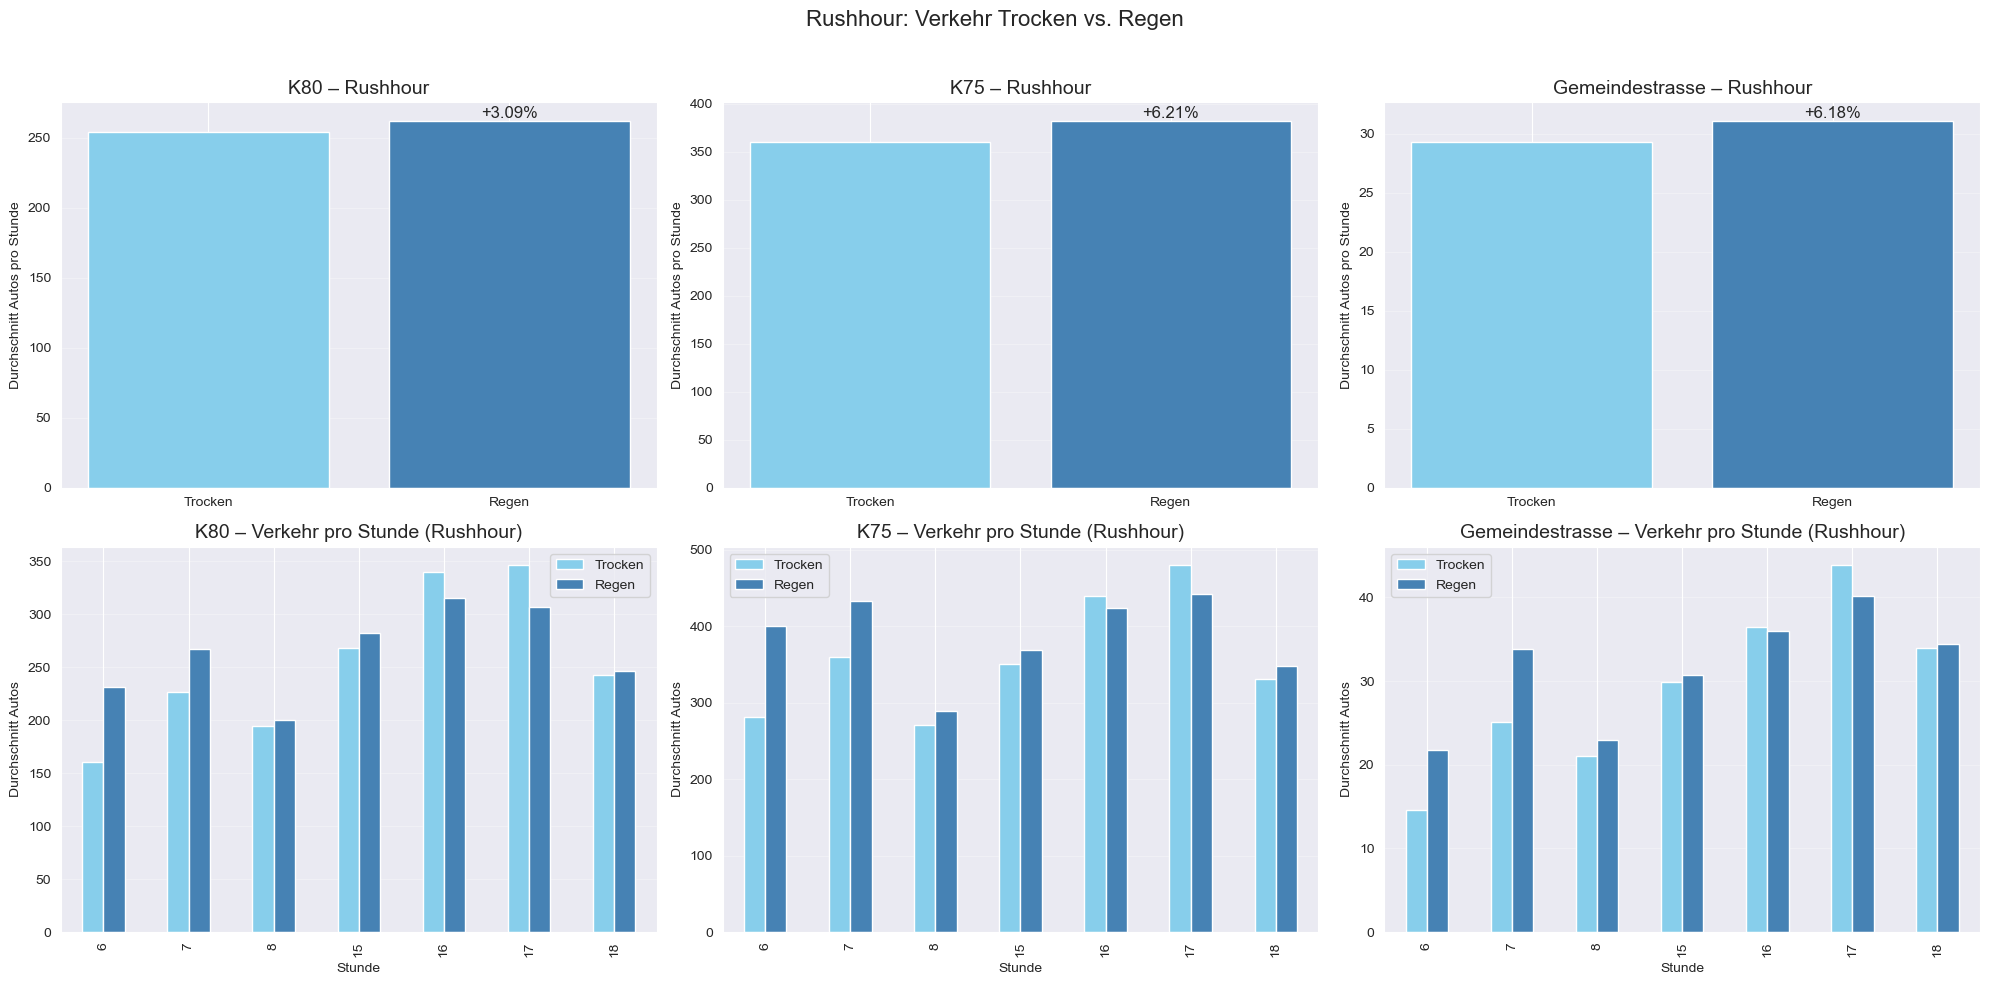


K80 – Nicht-Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    117.267633
True     107.978548
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -9.29 (-7.92%)

K75 – Nicht-Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    165.021160
True     160.640264
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -4.38 (-2.65%)

Gemeindestrasse – Nicht-Rushhour
False = trockene Stunden   |   True = Regenstunden
Regentag
False    14.294279
True     13.603960
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -0.69 (-4.83%)


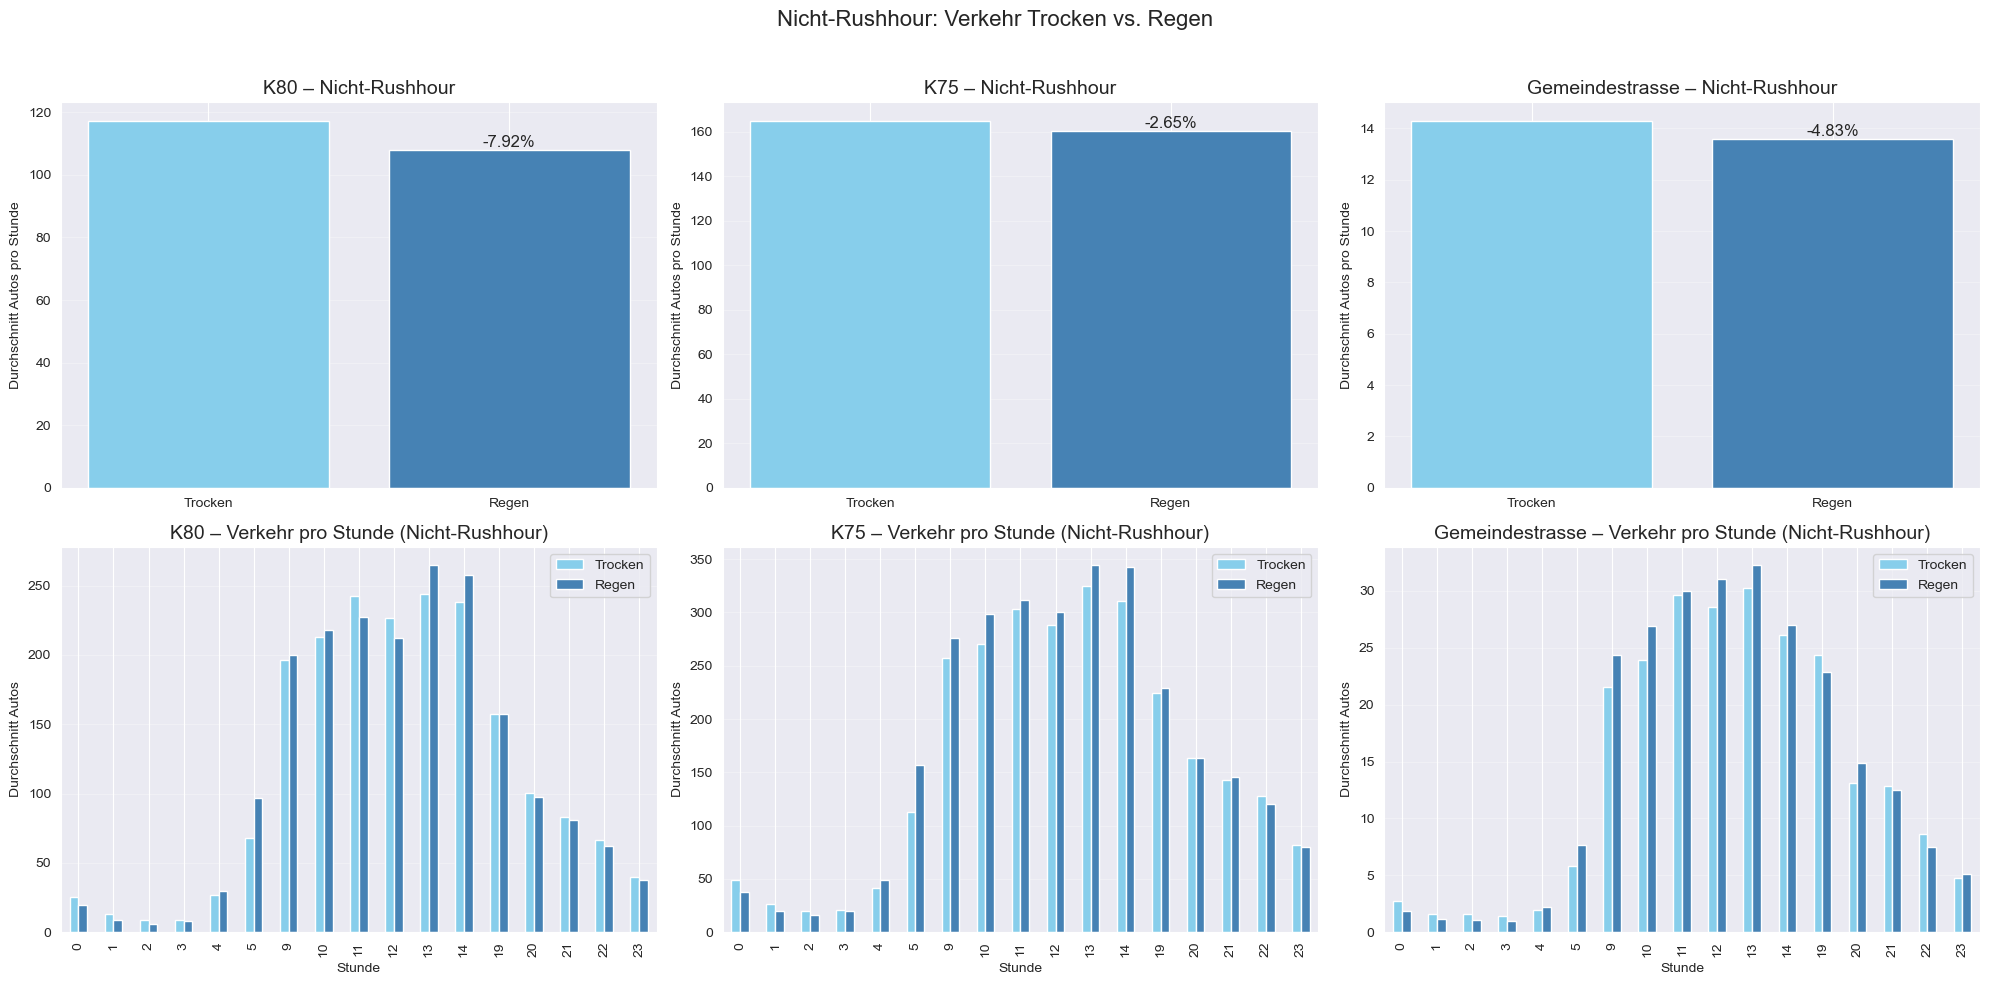


K80 – Gesamter Tag
False = trockene Stunden   |   True = Regenstunden
Regentag
False    158.157041
True     148.798544
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -9.36 (-5.92%)

K75 – Gesamter Tag
False = trockene Stunden   |   True = Regenstunden
Regentag
False    223.141364
True     219.292476
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -3.85 (-1.72%)

Gemeindestrasse – Gesamter Tag
False = trockene Stunden   |   True = Regenstunden
Regentag
False    18.761276
True     18.229369
Name: motorisiert_total, dtype: float64
Unterschied (Regen - Trocken): -0.53 (-2.84%)


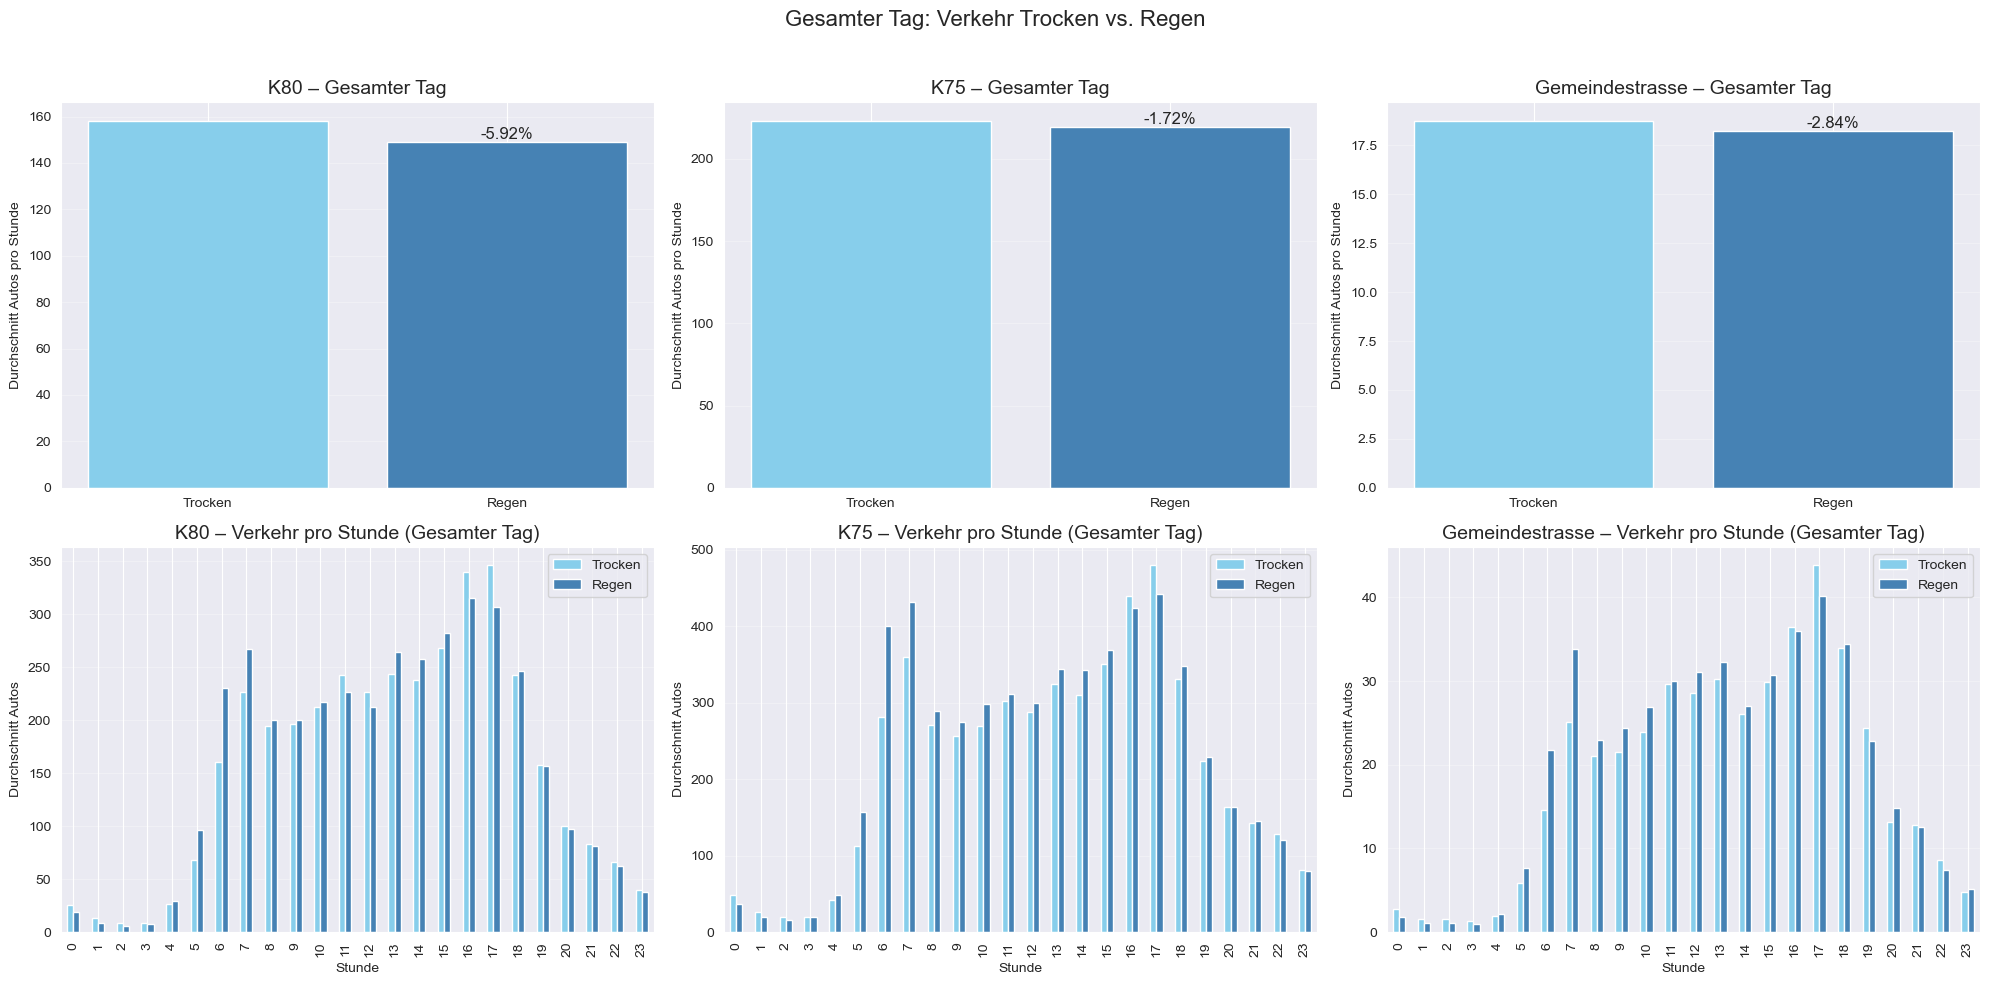

In [190]:
rushhour = [6, 7, 8, 15, 16, 17, 18]


def verkehr_vergleich(
    df, name, ax_total=None, ax_hourly=None, zeitbereich="rush"
):
    df = df.copy()
    df["Stunde"] = pd.to_datetime(df["zeit_von"]).dt.hour

    if zeitbereich == "rush":
        df_plot = df[df["Stunde"].isin(rushhour)]
        label = "Rushhour"
    elif zeitbereich == "nonrush":
        df_plot = df[~df["Stunde"].isin(rushhour)]
        label = "Nicht-Rushhour"
    else:
        df_plot = df
        label = "Gesamter Tag"

    df_plot["Regentag"] = df_plot["messwert"] > 0

    # Durchschnitt Gesamt
    gruppen_total = df_plot.groupby("Regentag")["motorisiert_total"].mean()

    # Konsolen-Output
    print(f"\n{name} – {label}")
    print("==========================================")
    print("False = trockene Stunden   |   True = Regenstunden")
    print(gruppen_total)

    if False in gruppen_total.index and True in gruppen_total.index:
        diff = gruppen_total[True] - gruppen_total[False]
        prozent = (diff / gruppen_total[False]) * 100
        print(f"Unterschied (Regen - Trocken): {diff:.2f} ({prozent:+.2f}%)")
    else:
        print("Keine ausreichenden Daten für beide Gruppen.")

    # Obere Reihe: Gesamtvergleich Trocken vs. Regen
    if ax_total is not None:
        ax_total.bar(
            ["Trocken", "Regen"],
            gruppen_total.reindex([False, True], fill_value=0),
            color=["skyblue", "steelblue"],
        )
        ax_total.set_title(f"{name} – {label}", fontsize=14)
        ax_total.set_ylabel("Durchschnitt Autos pro Stunde")
        ax_total.grid(alpha=0.3, axis="y")
        if False in gruppen_total.index and True in gruppen_total.index:
            ax_total.text(
                1,
                gruppen_total[True],
                f"{prozent:+.2f}%",
                ha="center",
                va="bottom",
                fontsize=12,
            )

    # Untere Reihe: Durchschnitt pro Stunde
    if ax_hourly is not None:
        hourly = (
            df_plot.groupby(["Stunde", "Regentag"])["motorisiert_total"]
            .mean()
            .unstack(fill_value=0)
        )
        hourly.plot(kind="bar", ax=ax_hourly, color=["skyblue", "steelblue"])
        ax_hourly.set_title(
            f"{name} – Verkehr pro Stunde ({label})", fontsize=14
        )
        ax_hourly.set_xlabel("Stunde")
        ax_hourly.set_ylabel("Durchschnitt Autos")
        ax_hourly.grid(alpha=0.3, axis="y")
        ax_hourly.legend(["Trocken", "Regen"])


# Plots erstellen: 3x3 (Rushhour, Nicht-Rushhour, Gesamter Tag)
zeitbereiche = ["rush", "nonrush", "all"]

for zeit in zeitbereiche:
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    verkehr_vergleich(
        df_k80,
        "K80",
        ax_total=axes[0, 0],
        ax_hourly=axes[1, 0],
        zeitbereich=zeit,
    )
    verkehr_vergleich(
        df_k75,
        "K75",
        ax_total=axes[0, 1],
        ax_hourly=axes[1, 1],
        zeitbereich=zeit,
    )
    verkehr_vergleich(
        df_gemeinde,
        "Gemeindestrasse",
        ax_total=axes[0, 2],
        ax_hourly=axes[1, 2],
        zeitbereich=zeit,
    )
    titel = {
        "rush": "Rushhour",
        "nonrush": "Nicht-Rushhour",
        "all": "Gesamter Tag",
    }
    plt.suptitle(f"{titel[zeit]}: Verkehr Trocken vs. Regen", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Erkenntnisse
### Erkenntniss Roushhour
Es ist zu erkennen, dass während der Stosszeiten durchschnittlich mehr Fahrzeuge auf den Strassen unterwegs sind, was auf den Pendlerverkehr zurückzuführen ist. Bei Regen steigt das Verkehrsaufkommen zusätzlich an. Bei der K80 fällt der Unterschied jedoch mit nur 3,09% relativ gering aus, während der Effekt bei der K75 und der Gemeindestrasse mit 6,21% bzw. 6,18% deutlich ausgeprägter ist.

Zusätzlich verzeichnet die K80 im Vergleich zur K75 insgesamt ein geringeres Verkehrsaufkommen. Dies hängt vermutlich mit ihrer geografischen Lage zusammen: Die K80 dient in Weinfelden primär als Verbindung in den ländlichen Raum und zu kleineren Ortschaften südlich von Weinfelden, wie beispielsweise Büssnang oder Märwil.

Die K75 hingegen gehört zu den Hauptverkehrsachsen und verbindet Weinfelden direkt mit Frauenfeld. Sie wird zudem häufig als Ausweichroute zur Autobahn A7 genutzt, insbesondere bei Stau oder Regen. Da sich bei Regen die Staus auf den Schweizer Autobahnen tendenziell verstärken, weichen viele Autofahrer auf die K75 aus. Durch das häufige Umfahren der Autobahn kann es auf der K75 ebenfalls zu Staus kommen, wodurch manche Fahrer wiederum auf die Gemeindestrasse ausweichen und später zurück auf die K75 gelangen.

### Erkenntisse Nicht-Roushhour
Interessanterweise zeigt sich in den Nicht-Rushhours ein umgekehrtes Muster: Bei Regen fahren hier tendenziell weniger Fahrzeuge als bei trockenem Wetter. Dies lässt sich durch mehrere Faktoren erklären:

- **Reduzierter Freizeitverkehr:** Nicht-Rushhour-Verkehr besteht überwiegend aus Fahrten zu Freizeitaktivitäten, Einkäufen oder Terminen. Bei Regen entscheiden viele Menschen, solche Fahrten zu verschieben oder ganz ausfallen zu lassen.
- **Sicherheits- und Komfortverhalten:** Weniger erfahrene oder vorsichtigere Fahrer vermeiden Fahrten bei schlechten Wetterbedingungen, insbesondere wenn sie nicht zwingend notwendig sind.
- **Flexibilität des Verkehrs:** Anders als Pendler können Fahrer ausserhalb der Stosszeiten ihre Fahrten flexibel anpassen, z.B. Homeoffice nutzen oder Termine verschieben.

Insgesamt zeigt sich somit, dass Regen den Verkehr ausserhalb der Rushhour eher reduziert, während er während der Rushhour die Nutzung der Hauptverkehrsachsen sogar verstärken kann.

### Erkenntnisse über den ganzen Tag
Betrachtet man den gesamten Tagesverlauf, bestätigt sich das Bild: Bei Regen sinkt das Verkehrsaufkommen insgesamt leicht, da insbesondere der Freizeit- und Nebenverkehr reduziert wird. Gleichzeitig kann Regen jedoch an kritischen Punkten wie Hauptachsen oder Umfahrungsstrecken zu lokalen Stauungen führen, da Pendler und notwendige Fahrten weiterhin stattfinden.

# LE 5 Datenpipeline

Für die Datenpipeline werden zwei Datensätze kombiniert:  
**Data1** (Strassenbefahrungen / Verkehrsdaten) und **Data2** (Regendaten und Indikatoren).

Ziel ist es, beide Datensätze zu bereinigen, zu transformieren und über gemeinsame Zeit- und Datumsangaben zu verbinden.  
Die Pipeline besteht aus mehreren Teilschritten (Cleaning, Transformation, Merge, Filterung) und wird über eine zentrale Klasse gesteuert.

Wir erstellen eine Datenpipeline, da sie den gesamten Prozess von der Datenbereinigung bis zur Zusammenführung strukturiert, automatisiert und reproduzierbar macht.  
Der Vorteil einer Pipeline liegt in der klaren Struktur und Nachvollziehbarkeit:  
Alle Verarbeitungsschritte sind automatisiert, nachvollziehbar und auf Knopfdruck erneut ausführbar.  
So können Datenfehler oder Anpassungen effizient korrigiert werden, ohne einzelne Schritte manuell wiederholen zu müssen.
Die Pipeline besteht aus drei klar getrennten Schritten:  
1. **Data1 – Bereinigung und Transformation:**  
   Die Rohdaten werden eingelesen, nach Gemeinde gefiltert, Datentypen vereinheitlicht, Zeitvariablen abgeleitet und relevante Spalten berechnet (z. B. Fahrzeugkategorien).  
2. **Data2 – Bereinigung und Transformation:**  
   Die Parquet-Datei mit Regendaten wird geladen, Datums- und Zeitspalten erstellt und nach Jahr und Messstelle gefiltert.  
3. **Merge – Kombination der beiden Datensätze:**  
   Beide bereinigten DataFrames werden über gemeinsame Zeit- und Datumsfelder zusammengeführt und nach Strassen (K80, K75, Gemeindestrasse) gefiltert.


Die logs der transformationen werden im logs Folder gespeichert. Die Pipenline befindet sich im pipeline.py file, von dem wir auch die folgenden Imports machen.


In [191]:
from Python.pipeline import Config, Data1Pipeline, Data2Pipeline, MergePipeline

In [192]:
cfg = Config()
d1 = Data1Pipeline(cfg)
d2 = Data2Pipeline(cfg)
merge = MergePipeline(cfg)

### Schritt für Schritt Beispiel

Hier zeigen wir, dass diese Pipeline sowohl zusammen geht, als auch wie hier Schritt für Schritt.
Bei unserem Beispiel hier, führen wir ein Paar Schritte einzeln nur für Data1 aus. Wir laden die Daten, wandeln sie zu richtigen Datentypen um und setzen dummy Variablen.

In [193]:
df1 = d1.load()
df1 = d1.cast_types(df1)
df1 = d1.encode_binary(df1)

2025-12-29 15:38:38,596 | INFO | Data1 | Lade Data1: C:\Users\silas\OneDrive\FHNW\05_Semester\SKO\SKO_Uebung_1\Data\Data_1_neu.csv
2025-12-29 15:38:41,088 | INFO | Data1 | Setze Datentypen für Data1
2025-12-29 15:38:41,108 | INFO | Data1 | Kodierung JA/Nein → 1/0


### Schritte zusammen ausführen
Hier zeigen wir, wie alle Schritte zusammen mit den run funktionen ausgeführt werden können.

In [194]:
data1_processed = d1.run()
data2_processed = d2.run()
combined, streets = merge.run(data1_processed, data2_processed)

2025-12-29 15:38:41,129 | INFO | Data1 | Starte DATA1 PIPELINE
2025-12-29 15:38:41,130 | INFO | Data1 | Lade Data1: C:\Users\silas\OneDrive\FHNW\05_Semester\SKO\SKO_Uebung_1\Data\Data_1_neu.csv
2025-12-29 15:38:43,607 | INFO | Data1 | Setze Datentypen für Data1
2025-12-29 15:38:43,632 | INFO | Data1 | Kodierung JA/Nein → 1/0
2025-12-29 15:38:43,636 | INFO | Data1 | Konvertiere Datum/Zeit
2025-12-29 15:38:43,696 | INFO | Data1 | Benenne Spalten um
2025-12-29 15:38:43,720 | INFO | Data1 | Übersetze englische Wochentage → deutsch
2025-12-29 15:38:43,722 | INFO | Data1 | Leite Zeitvariablen ab
2025-12-29 15:38:43,734 | INFO | Data1 | Aggregiere Fahrzeugkategorien
2025-12-29 15:38:43,739 | INFO | Data1 | Filtere Data1 auf Jahr 2024
2025-12-29 15:38:43,759 | INFO | Data1 | Entferne nicht benötigte Spalten
2025-12-29 15:38:43,767 | INFO | Data1 | Data1 Pipeline abgeschlossen
2025-12-29 15:38:43,775 | INFO | Data2 | Starte DATA2 PIPELINE
2025-12-29 15:38:43,776 | INFO | Data2 | Lade Data2: C:\

# Fazit

Das Projekt war deutlich anspruchsvoller und zeitaufwändiger als zunächst angenommen. Auch die Analyse von NAs war nicht so direkt ersichtlich wie erhofft. Zudem haben wir die Zeitstempel als wichtigen Faktor unterschätzt. Erst nach einer klaren Aufteilung der Daten in spezifische Gemeinden und Zeiträume wurde deutlich, dass die ursprünglich ausgewählten Daten nicht übereinstimmten. Daraufhin mussten wir unsere Fragestellung anpassen, da es in unserem Fall sinnvoller war, als neue Daten zu suchen und von vorne anzufangen. Erst nach einer erneuten Vereinigung konnten wir mit der eigentlichen Analyse beginnen.

Die erzeugten Plots verdeutlichten, wie stark der Tagesverlauf den Verkehr prägt und wie ungleichmässig Regen über die Tage verteilt ist. Gleichzeitig zeigten die Visualisierungen, dass Regen nur geringe Auswirkungen auf das allgemeine Verkehrsaufkommen hat und keine klaren Muster entstehen, die auf einen deutlichen Zusammenhang hindeuten würden. Trotz kleiner Unterschiede zwischen Stosszeiten mit und ohne Niederschlag blieb der Einfluss insgesamt schwach.

Insgesamt war es eine spannende Arbeit und wir konnten vieles lernen für unsere weiteren Projekte. 